# Final Capstone Overview
Pitchfork (https://pitchfork.com) is an online music publication with a focus on indie music news and reviews. Ryan Schreiber launched the site independently in 1995, and Condé Nast acquired it in 2015. For my final capstone, I'll build a recommendation system based on the site's editorial reviews. 

I wrangled approximately 6,000 music reviews for this project, using web scraping and an unofficial API licensed by MIT (https://pypi.org/project/pitchfork). Below, I'll explore the dataset and prepare text for modeling, apply clustering algorithms to inform recommendations, perform sentiment analysis with supervised learning, and then use that analysis to find positive sentences in reviews.

Ultimately, I hope this project will present a new way to engage Pitchfork readers with the publication and connect them with new music they might enjoy.

# Importing Dependencies

In [53]:
# imports libraries for:
# data handling and exploration:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import string
import re
import spacy
import unicodedata
from collections import Counter
import nltk
from nltk import tokenize

# visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import Doc2Vec

# clustering and modeling:
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble

# validation:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [54]:
# imports data
music_df = pd.read_csv('music_df.csv')

In [55]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6043 entries, 0 to 6042
Data columns (total 8 columns):
abstract     6043 non-null object
album        6043 non-null object
artist       6042 non-null object
date         6043 non-null object
editorial    6043 non-null object
genre        5743 non-null object
rating       6043 non-null float64
url          6043 non-null object
dtypes: float64(1), object(7)
memory usage: 377.8+ KB


In [56]:
# sets date data type to datetime
music_df['date'] = pd.to_datetime(music_df['date'])

# creates year variable
music_df['year'] = pd.DatetimeIndex(music_df['date']).year

In [57]:
# checks instance where artist is null 
music_df[music_df.artist.isna() == True]

abstract      album artist  \
4070  Producer Daniel Pineda, who is one half of Ngu...  Cellar EP    NaN   

           date                                          editorial  \
4070 2016-02-29  Working with a large cohort of friends and col...   

           genre  rating                               url  year  
4070  Electronic     7.5  /reviews/albums/21611-cellar-ep/  2016

In [58]:
# fills with 'NA' (band's name)
music_df.artist.fillna('NA', inplace=True)

In [59]:
music_df.head()

abstract                   album  \
0  The Chicago-bred singer and producer’s homegro...        Forever, Ya Girl   
1  After two albums of insular restraint, the ele...  A Muse in Her Feelings   
2  Seven years after his breakout hit, the UK hou...                 Duality   
3  The absurdly detailed new album from the Chica...                    Ajai   
4  The  Buffalo rapper continues his unlikely asc...          Pray For Paris   

          artist       date  \
0         KeiyaA 2020-04-22   
1           dvsn 2020-04-22   
2    Duke Dumont 2020-04-22   
3      Serengeti 2020-04-22   
4  Westside Gunn 2020-04-21   

                                           editorial       genre  rating  \
0  Ever since an artist once known as Lonny Breau...     Pop/R&B     8.2   
1  Daniel Daley has a voice so striking that it’s...     Pop/R&B     7.0   
2  Duke Dumont rode the mid-2010s wave of radio-f...  Electronic     5.2   
3  For almost 20 years now, Nike has asked young ...         Rap     8.0   
4  There was a time when Westside Gunn and his Gr...         Rap     8.0   

                                             url  year  
0        /reviews/albums/keiyaa-forever-ya-girl/  2020  
1   /reviews/albums/dvsn-a-muse-in-her-feelings/  2020  
2           /reviews/albums/duke-dumont-duality/  2020  
3                /reviews/albums/serengeti-ajai/  2020  
4  /reviews/albums/westside-gunn-pray-for-paris/  2020

In [60]:
music_df.sample(5)

abstract             album  \
313   The Australian garage rock band’s first album ...  All in Good Time   
68    Without the self-assurance of her debut, the N...          Devotion   
2642  Nine Inch Nails’ second EP in a year is as per...   Add Violence EP   
366   Pieced together from four Merriweather Post Pa...   Ballet Slippers   
3167  Brokenlegged is a rich and multifaceted emo re...      Brokenlegged   

                             artist       date  \
313   Eddy Current Suppression Ring 2020-01-02   
68                  Margaret Glaspy 2020-03-31   
2642                Nine Inch Nails 2017-07-26   
366               Animal Collective 2019-11-28   
3167                   Sinai Vessel 2017-01-25   

                                              editorial         genre  rating  \
313   Aside from an occasional one-off live set, Edd...    Electronic     6.3   
68    Margaret Glaspy’s 2016 debut Emotions & Math w...          Rock     5.3   
2642  It’s a scary time for Nine Inch Nails. Not tha...          Rock     7.3   
366   A decade since Merriweather Post Pavilion, the...  Experimental     7.4   
3167  The title of Labor Pains was wasted on Sinai V...          Rock     7.7   

                                                    url  year  
313   /reviews/albums/eddy-current-suppression-ring-...  2020  
68            /reviews/albums/margaret-glaspy-devotion/  2020  
2642   /reviews/albums/nine-inch-nails-add-violence-ep/  2017  
366   /reviews/albums/animal-collective-ballet-slipp...  2019  
3167                /reviews/albums/22793-brokenlegged/  2017

# EDA
Before diving into the text, I'll look at the distribution of rating, genre, and year across the dataset. I'll also explore length of reviews.

In [61]:
sns.set(style='whitegrid', palette="deep", font_scale=1.3, rc={"figure.figsize": [10, 6]})

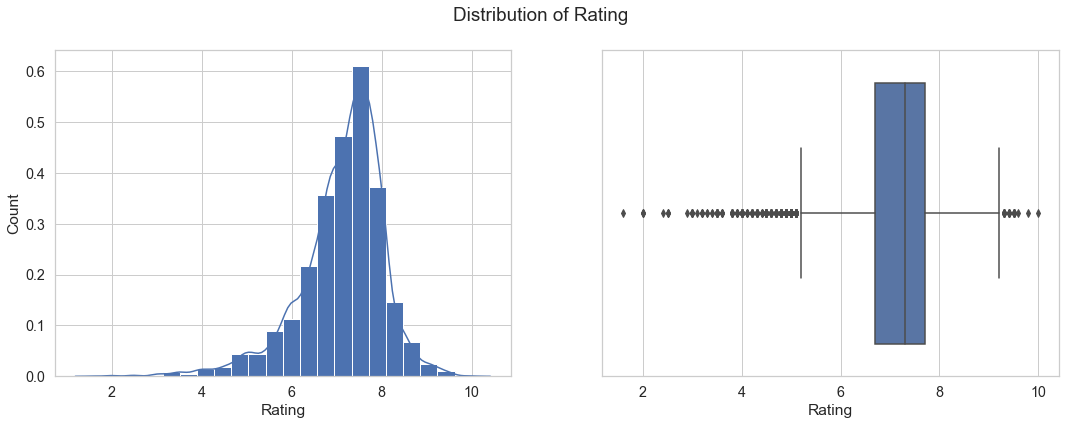

In [14]:
# plots distribution of rating variable
plt.figure(figsize=(18,6))
plt.suptitle('Distribution of Rating')

plt.subplot(1,2,1)
sns.distplot(
    music_df['rating'], bins=22, hist_kws={"alpha": 1}).set(xlabel='Rating', ylabel='Count')

plt.subplot(1,2,2)
sns.boxplot(
    music_df['rating']).set(xlabel='Rating');

In [15]:
# rating statistics
music_df.rating.describe()

count    6043.000000
mean        7.123184
std         0.933552
min         1.600000
25%         6.700000
50%         7.300000
75%         7.700000
max        10.000000
Name: rating, dtype: float64

In [16]:
# most common ratings
music_df['rating'].value_counts().sort_values(ascending=False).head(5)

7.4    375
7.6    368
7.8    354
7.7    340
8.0    337
Name: rating, dtype: int64

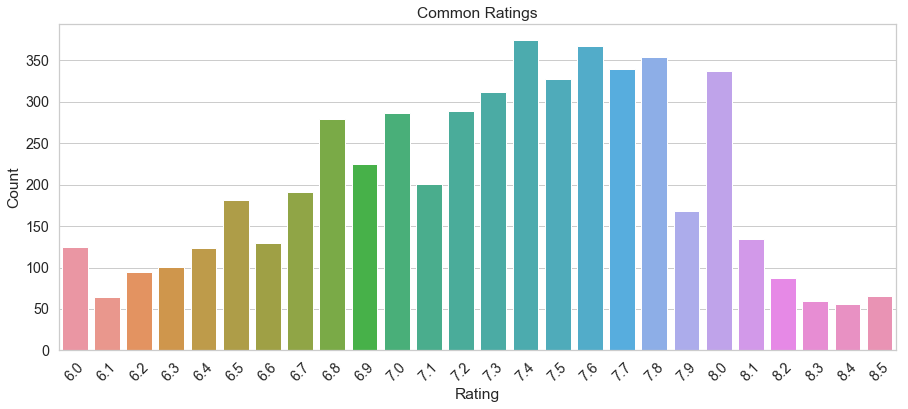

In [17]:
# plots common ratings
plt.figure(figsize=(15,6))
sns.countplot(
    music_df[music_df['rating'].between(6,8.5)]['rating']).set(
    xlabel='Rating', ylabel='Count', title='Common Ratings')
plt.xticks(rotation=45);

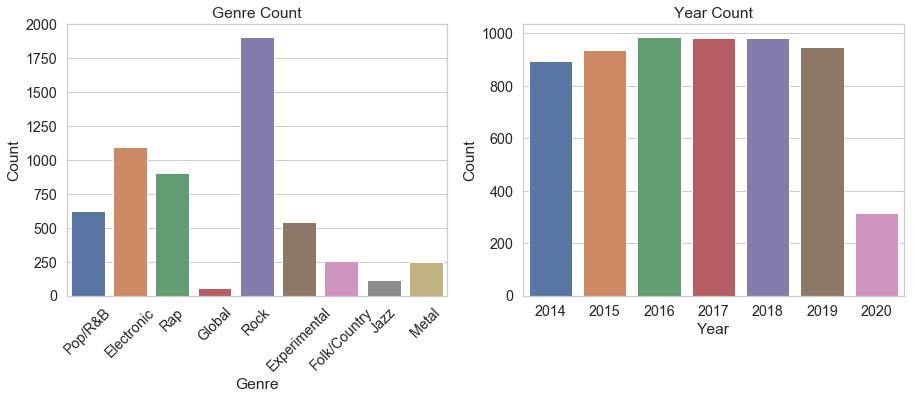

In [18]:
# plots counts of genre and year
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
sns.countplot(
    music_df['genre']).set(xlabel='Genre', ylabel='Count', title='Genre Count')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.countplot(
    pd.DatetimeIndex(music_df['date']).year).set(xlabel='Year', ylabel='Count', title='Year Count');

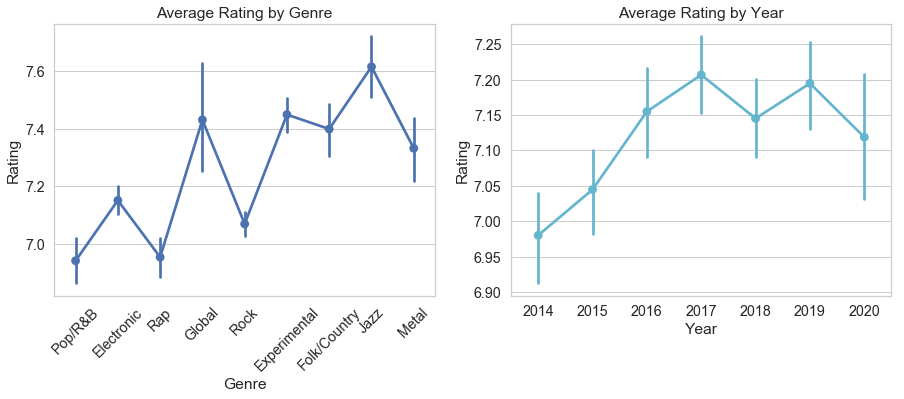

In [19]:
# plots average rating by genre and year
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
sns.pointplot(
    x= 'genre', y='rating', data=music_df).set(
    xlabel='Genre', ylabel='Rating', title='Average Rating by Genre')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.pointplot(
    x= 'year', y='rating', data=music_df, color='c').set(
    xlabel='Year', ylabel='Rating', title='Average Rating by Year');

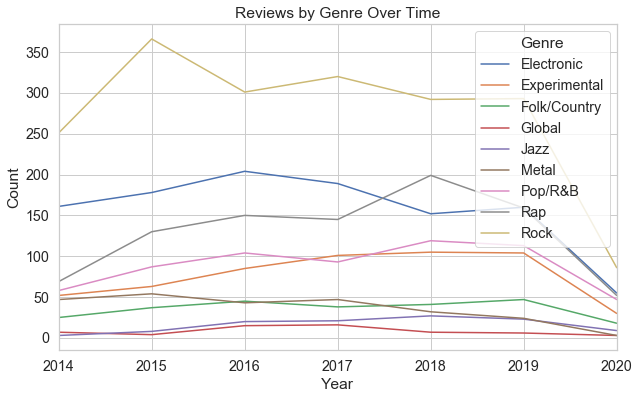

In [20]:
# plots number of reviews by genre over time
df_plot = music_df.groupby(['year', 'genre']).size().reset_index().pivot(columns='genre', index='year', values=0)

df_plot.plot(kind='line').set(
    xlabel='Year', ylabel='Count', title='Reviews by Genre Over Time')
plt.legend(loc='upper right', title='Genre');

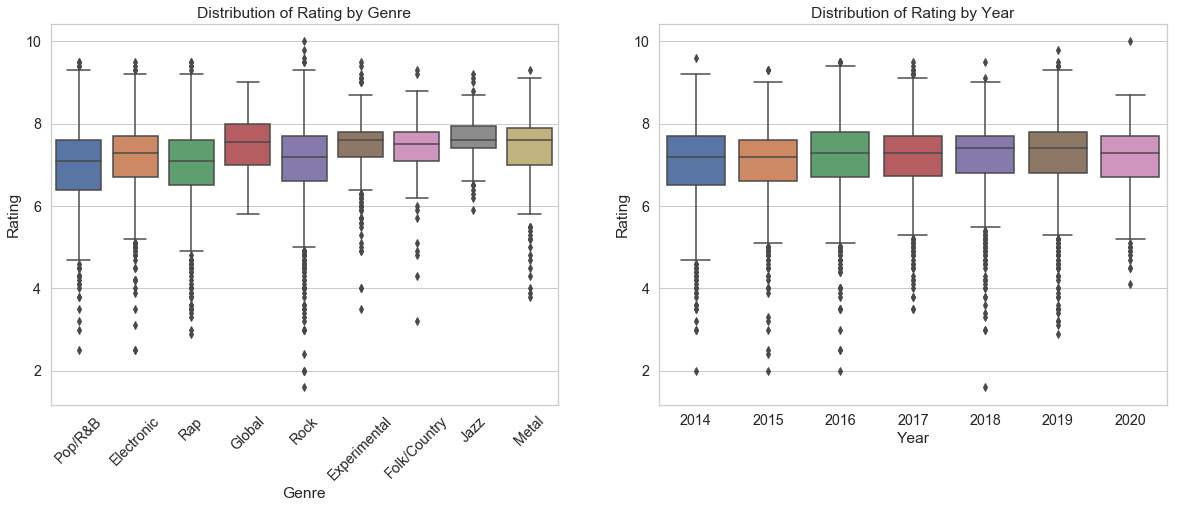

In [21]:
# plots distributions of rating by genre and year
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
sns.boxplot(
    x='genre', y='rating', data=music_df).set(
    xlabel='Genre', ylabel='Rating', title='Distribution of Rating by Genre')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.boxplot(
    x='year', y='rating', data=music_df).set(
    xlabel='Year', ylabel='Rating', title='Distribution of Rating by Year');

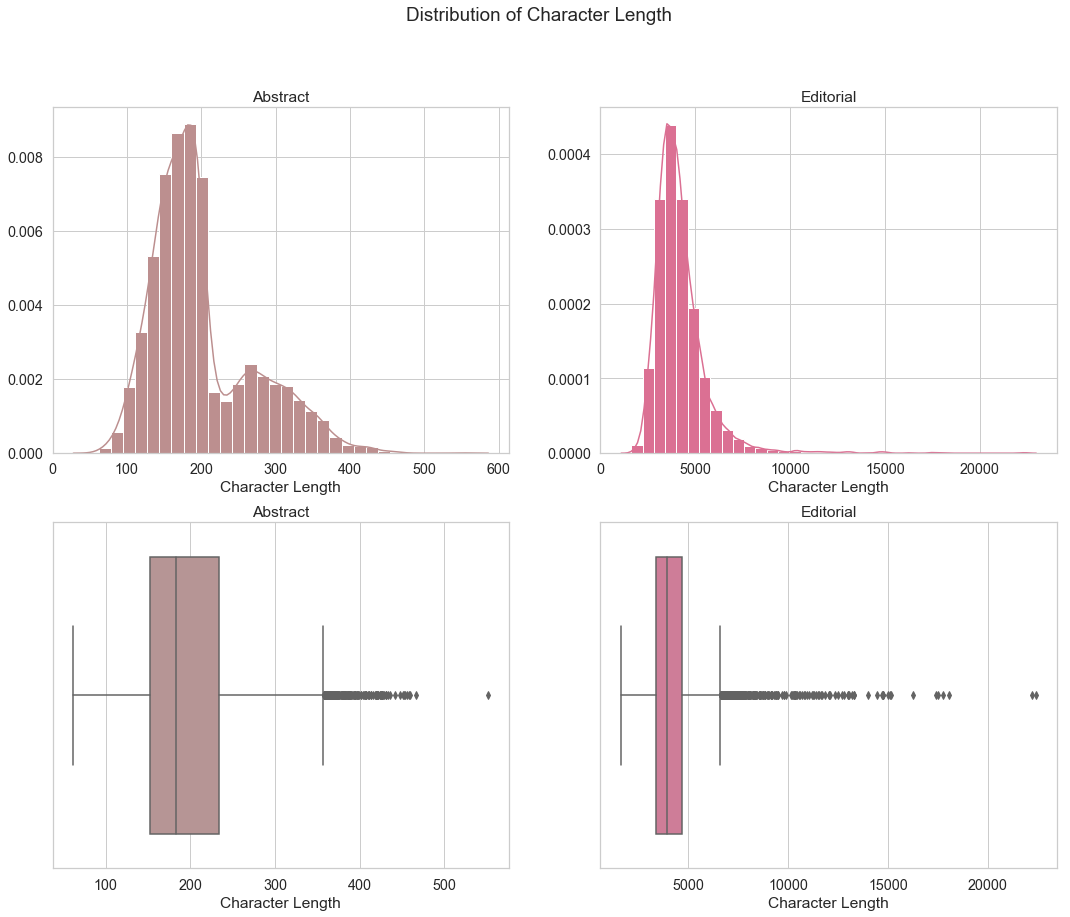

In [22]:
# plots character length in abstracts and editorials
# the abstract is a 1-2 sentence summary before the full editorial review
plt.figure(figsize=(18, 14))
plt.suptitle('Distribution of Character Length')

plt.subplot(2,2,1)
sns.distplot(
    music_df['abstract'].str.len(), color='rosybrown', bins=30, hist_kws={"alpha": 1}).set(
    xlabel='Character Length', title='Abstract')

plt.subplot(2,2,2)
sns.distplot(
    music_df['editorial'].str.len(), color='palevioletred', bins=35, hist_kws={"alpha": 1}).set(
    xlabel='Character Length', title='Editorial')

plt.subplot(2,2,3)
sns.boxplot(
    music_df['abstract'].str.len(), color='rosybrown').set(xlabel='Character Length', title='Abstract')

plt.subplot(2,2,4)
sns.boxplot(
    music_df['editorial'].str.len(), color='palevioletred').set(xlabel='Character Length', title='Editorial');

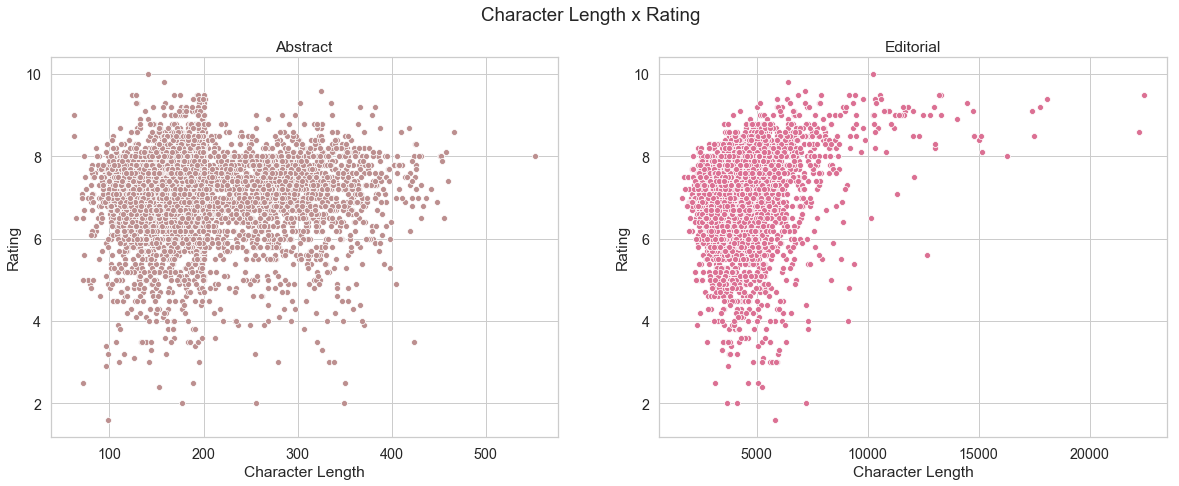

In [23]:
# plots character length x rating
plt.figure(figsize=(20, 7))
plt.suptitle('Character Length x Rating')

plt.subplot(1,2,1)
sns.scatterplot(x=music_df['abstract'].str.len(), y=music_df['rating'], color='rosybrown').set(
    xlabel='Character Length', ylabel='Rating', title='Abstract')

plt.subplot(1,2,2)
sns.scatterplot(x=music_df['editorial'].str.len(), y=music_df['rating'], color='palevioletred').set(
    xlabel='Character Length', ylabel='Rating', title='Editorial');

In [14]:
print('Pearson Correlation Tests:')
print('Abstract length and rating: {}'.format(pearsonr(music_df['abstract'].str.len(), music_df['rating'])))
print('Editorial length and rating: {}'.format(pearsonr(music_df['editorial'].str.len(), music_df['rating'])))

Pearson Correlation Tests:
Abstract length and rating: (0.019093792523257443, 0.1377777987914839)
Editorial length and rating: (0.21835979760129143, 3.829634056475668e-66)


### **Observations**
- Most albums, over 75%, recieve a rating between 6 and 8. The average rating is 7.1.
- Pitchfork recognizes 9 music genres, but focuses heavily on Rock music.
- There has been a slight increase in average rating since 2014.
- On average, Jazz records are rated highest; and Pop/R&B and Rap records are rated lowest.
- The character length of editorial reviews has a positive correlation with rating.

# Text Preprocessing and Exploration

In [100]:
# creates column with all text, abstract and editorial
music_df['all_text'] = music_df['abstract'].str.cat(music_df['editorial'],sep=' ')

In [101]:
# lower cases
music_df['all_text'] = music_df['all_text'].str.lower()

# replaces dashes with spaces
music_df['all_text'] = music_df['all_text'].str.replace('—', ' ')
music_df['all_text'] = music_df['all_text'].str.replace('-', ' ')

# replaces html with spaces
music_df['all_text'] = music_df['all_text'].str.replace(u'\xa0', ' ')
music_df['all_text'] = music_df['all_text'].str.replace(u'\n', ' ')
music_df['all_text'] = music_df['all_text'].str.replace(u'\u205f', ' ')

# removes text within quotes-- usually indicates lyrics, song titles, artist quotes
music_df['all_text'] = music_df['all_text'].replace('“(.+?)” ', '', regex=True)

# removes links to buy albums
music_df['all_text'] = music_df['all_text'].replace('buy:(.+?)\) ', '', regex=True)

# removes punctuation, numbers, and special characters
music_df['all_text'] = music_df['all_text'].replace('[^A-Za-z ]', '', regex=True)

In [102]:
# removes artist/band names from processed text in each row
for i in range(len(music_df)):
    artist_words = music_df.loc[i, 'artist'].split()
    for word in artist_words:
        word = word.lower() + ' '
        word2 = word.lower() + '\'s '
        music_df.loc[i, 'all_text'] = music_df.loc[i, 'all_text'].replace(word, '')
        music_df.loc[i, 'all_text'] = music_df.loc[i, 'all_text'].replace(word2, '')

In [103]:
# removes albums names from processed text in each row
for i in range(len(music_df)):
    album_words = music_df.loc[i, 'album'].split()
    for word in album_words:
        word = word.lower() + ' '
        word2 = word.lower() + '\'s '
        music_df.loc[i, 'all_text'] = music_df.loc[i, 'all_text'].replace(word, '')
        music_df.loc[i, 'all_text'] = music_df.loc[i, 'all_text'].replace(word2, '')

In [104]:
# replaces multiple spaces with single
music_df['all_text'] = music_df['all_text'].replace('\s\s+', ' ', regex=True)

# removes any trailing whitespace
music_df.loc[:, 'all_text'] = music_df.loc[:, 'all_text'].str.strip()

In [105]:
# counts frequent words
count_text = Counter()
for text in music_df['all_text'].values:
    for word in text.split():
        count_text[word] += 1

# stores top 500 words in a dataframe
stops_df = pd.DataFrame(count_text.most_common(500), columns=['word', 'frequency'])
stops_df

word  frequency
0             the     165641
1               a     114696
2              of     111490
3             and     110744
4              to      77110
..            ...        ...
495           use        809
496      releases        809
497       drummer        805
498  particularly        804
499          need        803

[500 rows x 2 columns]

In [106]:
# stores words that occur at least 10,000x in a list
stop_words = stops_df[stops_df['frequency'] >= 10000]['word'].to_list()
print('There are {} stopwords'.format(len(stop_words)))

There are 39 stopwords


In [108]:
# defines function to remove words
def remove_words(text, remove_list):
    return ' '.join([word for word in str(text).split() if word not in remove_list])

In [109]:
# removes stopwords
music_df.loc[:, 'all_text'] = music_df['all_text'].apply(lambda text: remove_words(text, stop_words))

In [71]:
# loads spacy
nlp = spacy.load('en')

In [110]:
# parses text with spacy
music_df.loc[:, 'all_text'] = [nlp(text) for text in music_df['all_text']]

In [111]:
# lemmatizes tokens
for i, tokens in enumerate(music_df.loc[:, 'all_text']):
    music_df.loc[i, 'all_text'] = ' '.join(
        [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in tokens])

In [112]:
# counts frequent lemmas
count_lemmas = Counter()
for text in music_df['all_text'].values:
    for word in text.split():
        count_lemmas[word] += 1

# stores top 500 words in a dataframe
stoplems_df = pd.DataFrame(count_lemmas.most_common(500), columns=['word', 'frequency'])
stoplems_df

word  frequency
0           s      22343
1         not      21642
2          be      20253
3        have      15587
4       sound      14590
..        ...        ...
495       eye        833
496   mixtape        833
497   history        832
498  consider        831
499    center        829

[500 rows x 2 columns]

In [113]:
# stores lemmas that occur at least 2,000x in a list
stop_lemmas = stoplems_df[stoplems_df['frequency'] >= 2000]['word'].to_list()

# removes 'not', which could be important for sentiment analysis
stop_lemmas.remove('not')

print('There are {} stop lemmas'.format(len(stop_lemmas)))

There are 192 stop lemmas


In [114]:
# removes frequent lemmas
music_df.loc[:, 'all_text'] = music_df['all_text'].apply(lambda text: remove_words(text, stop_lemmas))

In [115]:
music_df.sample(2)

abstract          album  \
1081  The second album by the French producer Gesaff...       Hyperion   
3818  The British experimental rock group Adult Jazz...  Earrings Off!   

             artist       date  \
1081  Gesaffelstein 2019-03-12   
3818     Adult Jazz 2016-05-26   

                                              editorial    genre  rating  \
1081  As Gesaffelstein, the French producer Mike Lév...  Pop/R&B     5.0   
3818  The British experimental rock group Adult Jazz...     Rock     6.0   

                                          url  year  \
1081  /reviews/albums/gesaffelstein-hyperion/  2019   
3818      /reviews/albums/21936-earrings-off/  2016   

                                               all_text  
1081  french bring collaborator haim pharrell french...  
3818  british experimental tackle theme gender bodys...

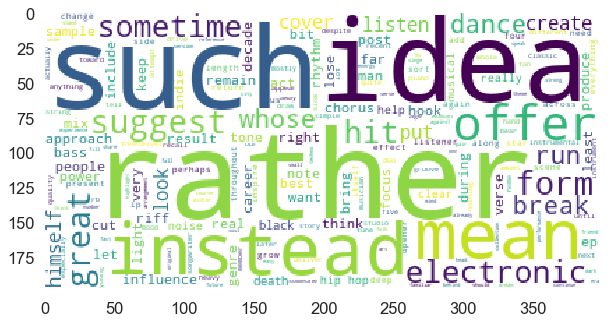

In [116]:
# visualizes frequent lemmas in all reviews
sns.set_style('dark')
plt.figure(figsize=(10,10))

wordcloud = WordCloud(
    background_color='white', stopwords=['not']).generate(' '.join(music_df['all_text']))

plt.imshow(wordcloud);

## Text Visualizations by Genre

In [117]:
# sets sns style
sns.set(style='dark', font_scale=1.5, rc={"figure.figsize": [10, 10]})

In [118]:
# defines function to plot wordclouds by genre
def plot_genre(genre, stops):
    dataframe = music_df[music_df['genre'] == genre]
    wordcloud = WordCloud(background_color='white', stopwords=stops).generate(
        ' '.join(dataframe['all_text']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(genre + ', ' + str(len(dataframe)) + ' Reviews');

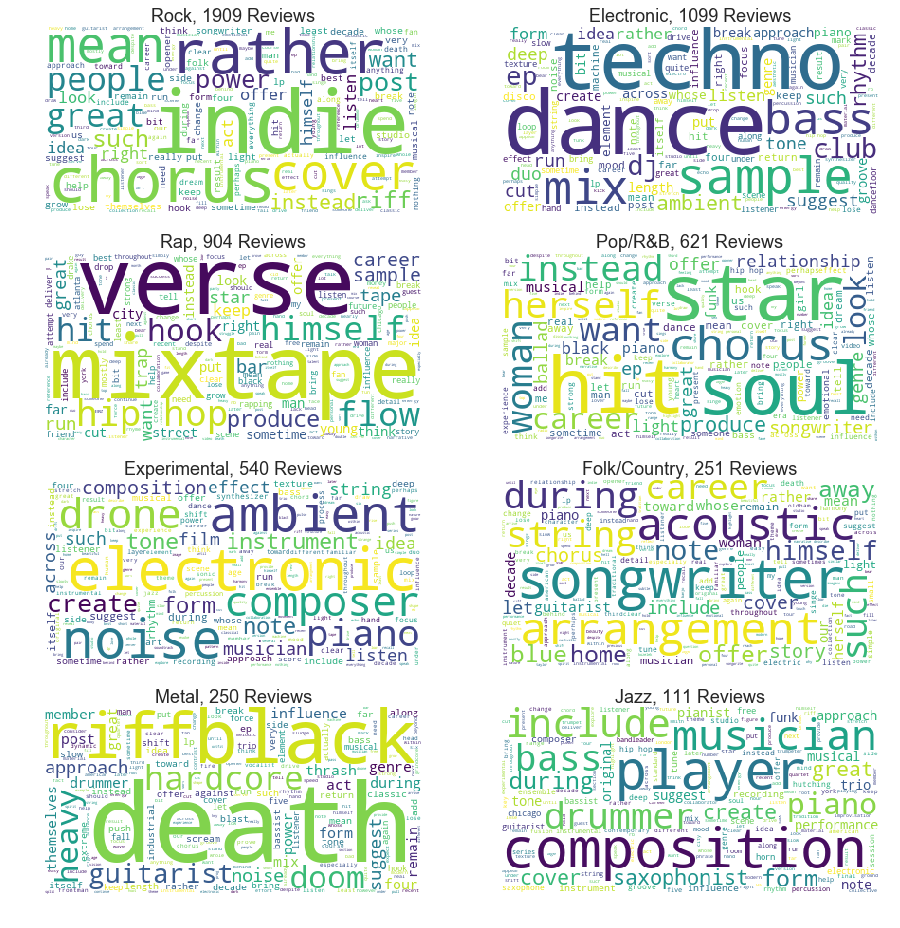

In [119]:
plt.figure(figsize=(15,16))
plt.subplot(4,2,1)
plot_genre('Rock', ['rock', 'not'])

plt.subplot(4,2,2)
plot_genre('Electronic', ['electronic', 'not'])

plt.subplot(4,2,3)
plot_genre('Rap', ['rap', 'rapper', 'not'])

plt.subplot(4,2,4)
plot_genre('Pop/R&B', ['pop', 'rb', 'not'])

plt.subplot(4,2,5)
plot_genre('Experimental', ['experimental', 'not'])

plt.subplot(4,2,6)
plot_genre('Folk/Country', ['folk', 'country', 'not'])

plt.subplot(4,2,7)
plot_genre('Metal', ['metal', 'not'])

plt.subplot(4,2,8)
plot_genre('Jazz', ['jazz', 'not'])

## Text Visualizations by Rating

In [87]:
# defines function to plot wordclouds by range of ratings
def plot_rating(x, y):
    dataframe = music_df[(music_df['rating'] > x) & (music_df['rating'] <= y)]
    wordcloud = WordCloud(background_color='white', stopwords=['not']).generate(
        ' '.join(dataframe['all_text']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Ratings ' + str(x) + '-' + str(y)+ ', ' + str(len(dataframe)) + ' Reviews');

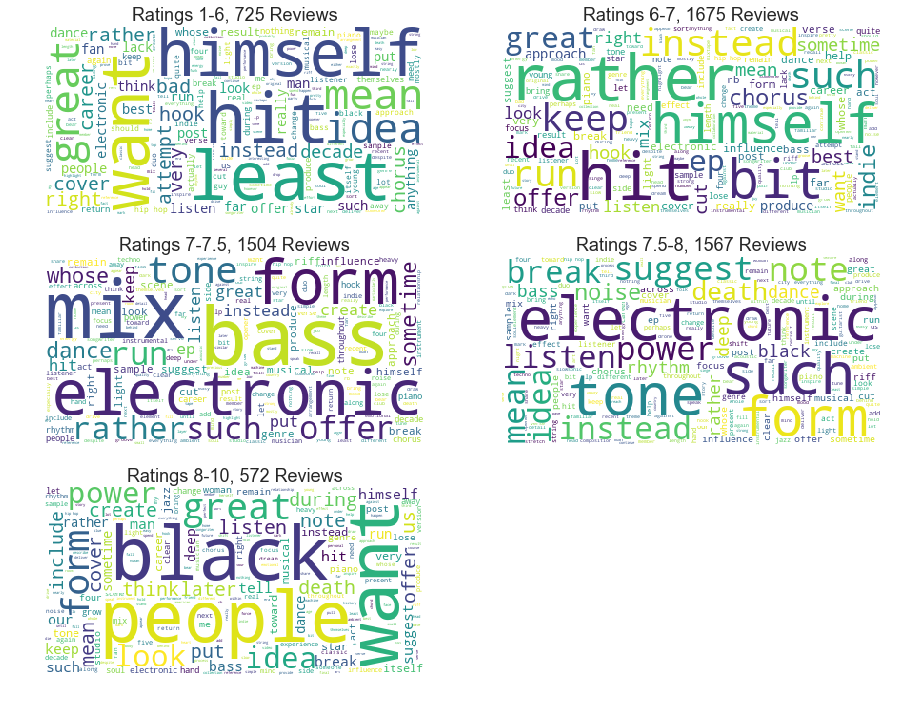

In [120]:
# plots wordclouds by rating
plt.figure(figsize=(15,12))
plt.subplot(3,2,1)
plot_rating(1,6)

plt.subplot(3,2,2)
plot_rating(6,7)

plt.subplot(3,2,3)
plot_rating(7,7.5)

plt.subplot(3,2,4)
plot_rating(7.5,8)

plt.subplot(3,2,5)
plot_rating(8,10)

### **Observations**
- In preprocessing the text, I removed 39 words from the original text and 192 lemmas after parsing with spaCy.
- Wordclouds by genre show some intuitive keywords (i.e. 'mixtape' and 'verse' in Rap reviews). Interestingly, 'woman' and 'herself' appear to be frequent in Pop/R&B, while 'himself' is more frequent in Rap and Folk/Country.
- Wordclouds by rating are not as clear. Most frequent words appear general or genre-related.

# Clustering Reviews and Content-Based Filtering

## Feature Engineering with TF-IDF

In [121]:
# defines tf-idf vectorizer-- unigrams and bigrams, min frequency 5
vectorizer = TfidfVectorizer(
    min_df=5, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range=(1,2))

# applies the vectorizer, creates a dataframe
X = vectorizer.fit_transform(music_df['all_text'])
vect_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df = pd.concat([vect_df, music_df[['artist', 'album', 'genre', 'rating', 'all_text']]], axis=1)

# prints a sample
tfidf_df.sample(2)

aa  aacm  aaliyah  aap  aap ferg  aap mob  aap rocky  aap rockys  \
1161  0.0   0.0      0.0  0.0       0.0      0.0        0.0         0.0   
2430  0.0   0.0      0.0  0.0       0.0      0.0        0.0         0.0   

      aaron  aaron bryce  ...  zorn  zorns   zs   zz  zz top  \
1161    0.0          0.0  ...   0.0    0.0  0.0  0.0     0.0   
2430    0.0          0.0  ...   0.0    0.0  0.0  0.0     0.0   

                   artist            album  genre  rating  \
1161  Wiz KhalifaCurren$y             2009    Rap     6.3   
2430               Common  Electric Circus    Rap     8.4   

                                               all_text  
1161  ostensible sequel fly offer fleeting glimpse e...  
2430  commons massive effort prince erykah badu phar...  

[2 rows x 36962 columns]

## Clustering with LSA

In [122]:
# SVD data reducer
svd = TruncatedSVD(400)

# LSA
lsa = make_pipeline(svd, Normalizer(copy=False))
X_lsa = lsa.fit_transform(tfidf_df.drop(['artist', 'album', 'genre', 'rating', 'all_text'], axis=1))

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 21.559181390785557


In [123]:
# stores components in a dataframe with labels from the original df
reviews_by_component = pd.DataFrame(X_lsa)
reviews_by_component['artist'] = tfidf_df['artist'].tolist()
reviews_by_component['album'] = tfidf_df['album'].tolist()
reviews_by_component['all_text'] = tfidf_df['all_text'].tolist()
reviews_by_component['rating_label'] = tfidf_df.iloc[:, 35284].tolist()
reviews_by_component['genre_label'] = tfidf_df.iloc[:, 35283].tolist()

In [124]:
reviews_by_component.sample(2)

0         1         2         3         4         5         6  \
2846  0.292215 -0.001125 -0.007561  0.026332  0.036837 -0.114588 -0.028512   
4804  0.309023 -0.061919 -0.098477 -0.041453 -0.049251  0.018554 -0.062446   

             7         8         9  ...       395       396       397  \
2846 -0.081010  0.060323 -0.030840  ... -0.009446  0.065857 -0.008501   
4804  0.125498  0.026873  0.030794  ...  0.005621 -0.003363  0.001614   

           398       399              artist       album  \
2846 -0.071263 -0.029116             Blondie  Pollinator   
4804  0.026615 -0.022169  Red House Painters     Box Set   

                                               all_text  rating_label  \
2846  collaboration sia dev hynes charli xcx blondie...           0.0   
4804  four lps remain magical beautiful mark kozelek...           0.0   

      genre_label  
2846          0.0  
4804          0.0  

[2 rows x 405 columns]

In [125]:
# defines function to plot wordclouds by component
def plot_comp(x):
    dataframe = reviews_by_component.loc[:,[x, 'all_text']].sort_values(by=x, ascending=False)
    wordcloud = WordCloud(background_color='white').generate(
        ' '.join(dataframe['all_text'][0:30]))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Component ' + str(x));

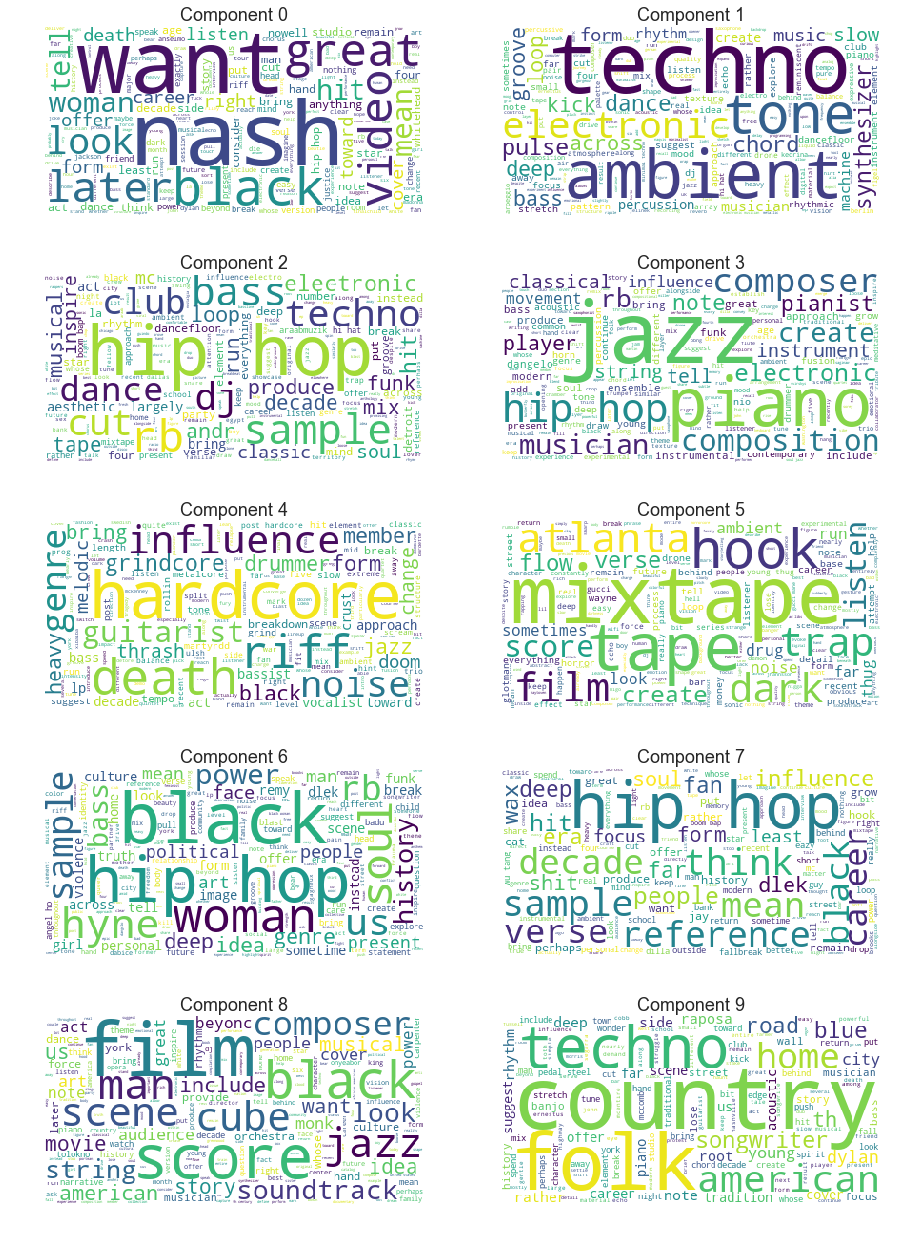

In [126]:
# plots first 10 components as wordclouds
x=1
plt.figure(figsize=(15,22))
for i in range(10):
    plt.subplot(5,2,x)
    plot_comp(i)
    x+=1

In [127]:
# checks correlations between components and rating
rating_corr = reviews_by_component.drop(['artist', 'album', 'genre_label', 'all_text'], 
                                        axis=1).corrwith(reviews_by_component['rating_label'])

In [128]:
rating_corr.sort_values()

106            -0.066476
394            -0.058559
214            -0.053991
280            -0.053586
192            -0.052950
                  ...   
353             0.054960
153             0.058097
75              0.062899
90              0.071251
rating_label    1.000000
Length: 401, dtype: float64

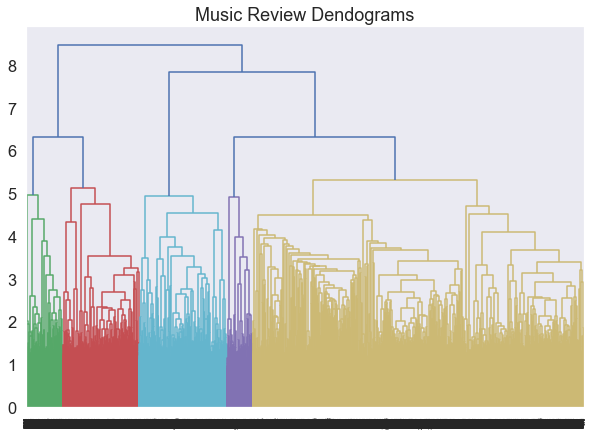

In [129]:
# plots dendrogram (agglomerative clustering, bottom up approach)
plt.figure(figsize=(10, 7))
plt.title("Music Review Dendograms")
dend = shc.dendrogram(shc.linkage(
    reviews_by_component.drop(['artist', 'album', 'genre_label', 'rating_label', 'all_text'], axis=1), method='ward'))

### **Observations**
- The model above appears to be clustering by genre. The wordclouds show some of the genre labels Pitchfork uses, like R&B and Folk, as well as some new ones, like Soul and Hip Hop. Component 8 appears to be related to film scores.
- None of the components are highly correlated with rating.
- The dendrogram visualization indicates 5 large clusters.

## Making Recommendations with Cosine Similarities
Nikita Sharma's article on recommender systems (https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831) was very helpful in building the model below.


In [130]:
# creates list of elements for document labels
all_artists = music_df['artist'].tolist()
all_albums = music_df['album'].tolist()

# creates a list of document labels
doc_labels = []

for i in range(len(all_artists)):
    new_label = all_artists[i] + ', ' + all_albums[i]
    doc_labels.append(new_label)
    
print('There are {} labels'.format(len(doc_labels)))

There are 6043 labels


In [131]:
# adds labels to dataframe
music_df['doc_labels'] = doc_labels

In [132]:
# computes distance between albums
cosine_similarities = linear_kernel(X_lsa, X_lsa) 
results = {}
for idx, row in music_df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_reviews = [(cosine_similarities[idx][i], music_df['doc_labels'][i]) for i in similar_indices] 
    results[row['doc_labels']] = similar_reviews[1:]

In [133]:
# defines function to return album info
def get_info(doc_label):  
    i = music_df.loc[music_df['doc_labels'] == doc_label].index[0]
    return music_df.loc[i]['doc_labels'] + ' -- ' + music_df.loc[i]['abstract']

# defines function to return 3 similar albums
def recommend(artist_album):
    print('Here are 3 albums similar to ' + artist_album + ':')
    recs = results[artist_album][:3]
    x = 1
    for rec in recs: 
        print('\n' + str(x) + '. ' + get_info(rec[1]) + ' (score:' +      str(rec[0]) + ')')
        x+=1

In [134]:
# tests recommender
recommend('Beyoncé, Lemonade')

Here are 3 albums similar to Beyoncé, Lemonade:

1. Boots, WinterSpringSummerFall -- Beyoncé collaborator and producer/singer/rapper Boots' debut project works in the same realm of his contributions to Beyoncé, as he builds tense, pretty atmospheres with his sweeping production. His talent is capable, if not exactly distinctive.
 (score:0.6042422804312483)

2. Destiny’s Child, The Writing’s on the Wall -- Beyond its tabloid drama, the innovation of Destiny’s Child’s second album codified the sound of R&B at the turn of the millennium. It is stilletto-sharp, and laid the groundwork for Beyoncé’s career.
 (score:0.550567163063242)

3. Beyoncé, Homecoming: The Live Album -- Beyoncé’s historic Coachella set is preserved as a stunning live album that captures an artist at her peak, flexing her catalog and shining a light on the genius of black artists that came before her.
 (score:0.5272396223732417)


In [136]:
recommend('Esperanza Spalding, Emily’s D+Evolution')

Here are 3 albums similar to Esperanza Spalding, Emily’s D+Evolution:

1. Brittany Howard, Jaime -- The exceptional solo debut from the Alabama Shakes singer-songwriter is a thrilling opus that pushes the boundaries of voice, sound, and soul to new extremes.
 (score:0.40041006146444685)

2. Jeff Buckley, Sketches for My Sweetheart the Drunk -- Jeff Buckley died before completing his second album. Sketches for My Sweetheart the Drunk, compiling those sessions, gives a glimpse into an erratic mind that could be too mercurial for its own good.
 (score:0.396767387274067)

3. Flying Lotus, Flamagra -- On Steven Ellison’s sixth album, his sweeping jazz-funk feels limitless. It sounds more like a sketchbook with FlyLo crafting each minute with great care and technical dexterity.
 (score:0.39245230972092743)


In [137]:
recommend('Leif Vollebekk, New Ways')

Here are 3 albums similar to Leif Vollebekk, New Ways:

1. Doug Paisley, Starter Home -- Gracefully navigating the intersection of folk-rock and country, the gentle-voiced songwriter turns detailed images of domestic tranquility and promise into reflections on disappointment.
 (score:0.38258700832776393)

2. Lady Lazarus, Impossible Journey of My Soul Tonight -- Produced by Beau Sorenson and recorded at John Vanderslice’s Tiny Telephone, Melissa Ann Sweat’s fourth album as Lady Lazarus is a searching work of elemental folk minimalism.
 (score:0.3438290534465183)

3. Maps & Atlases, Lightlessness Is Nothing New -- After a six-year hiatus, the Chicago math-rock-turned-pop-rock act returns with a deceptively upbeat album inspired by the death of singer-guitarist Dave Davison’s father.
 (score:0.3359932043790399)


### **Observations**
- The above recommender is able to make meaningful recommendations. Most suggestions are within the same genre of the input. 
- In cases where an artist released or collaborated on more than one record in the dataset (like Beyoncé), the recommender seems to have a bias in favor of the artist's name.

## Feature Engineering with Doc2Vec
Doc2vec is an adaptation of word2vec that generates vectors for documents. 

In [138]:
# prepares text data for Doc2Vec
LabeledSentence = gensim.models.doc2vec.TaggedDocument
all_content_train = []
i=0
for review in music_df['all_text'].values:
    all_content_train.append(LabeledSentence(review, [doc_labels[i]]))
    i+=1
print('Number of texts processed: ', i)

Number of texts processed:  6043


In [141]:
# defines model, 200 vectors, min count 5
d2v_model = Doc2Vec(all_content_train, vector_size=200, min_count=5, dm=1, alpha=0.025, min_alpha=0.025)
# trains
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs, start_alpha=0.002, end_alpha=-0.016)

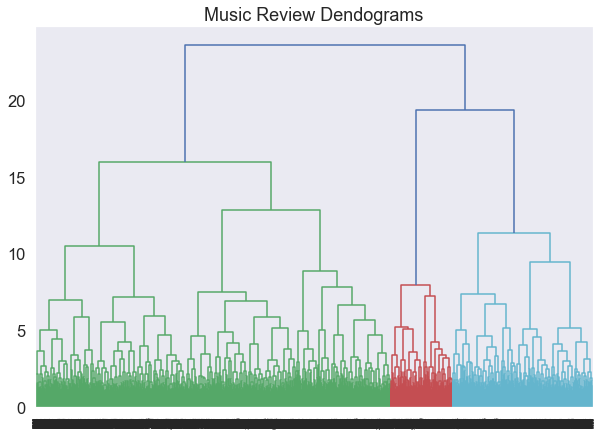

In [142]:
# plots dendrogram
plt.figure(figsize=(10, 7))
plt.title("Music Review Dendograms")
dend = shc.dendrogram(shc.linkage(d2v_model.docvecs.vectors_docs, method='ward'))

## Clustering with K Means

In [146]:
# 3 clusters
labels_1 = KMeans(n_clusters=3, random_state=414).fit_predict(d2v_model.docvecs.vectors_docs)
print(metrics.silhouette_score(d2v_model.docvecs.vectors_docs, labels_1, metric='euclidean'))
print(Counter(labels_1))

0.072098054
Counter({2: 2272, 1: 2066, 0: 1705})


In [144]:
# applies PCA to feature set for visualization
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

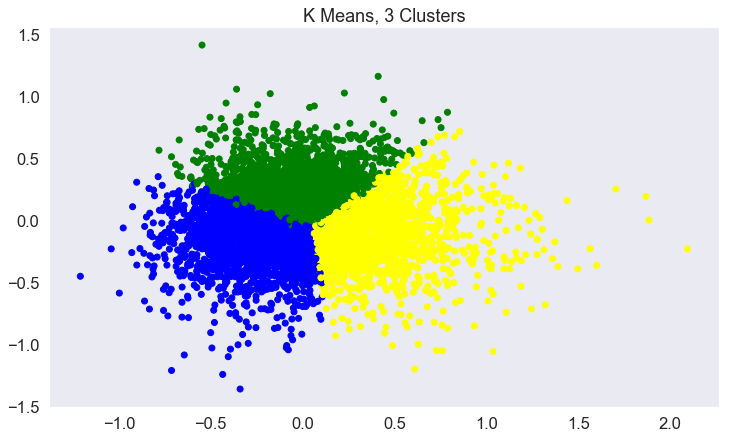

In [147]:
# plots clusters
plt.figure(figsize=(12,7))
label1 = ['#FFFF00', '#008000', '#0000FF']
color = [label1[i] for i in labels_1]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
plt.title('K Means, 3 Clusters')
plt.show()

In [148]:
# adds labels to dataframe
music_df['labels_1'] = labels_1

In [149]:
# defines function to plot wordclouds by label
def plot_label(label, x):
    dataframe = music_df[music_df[label] == x]
    wordcloud = WordCloud(background_color='white').generate(
        ' '.join(dataframe['all_text']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Cluster ' + str(x) + ', ' + str(len(music_df[music_df[label] == x])) + ' Reviews');

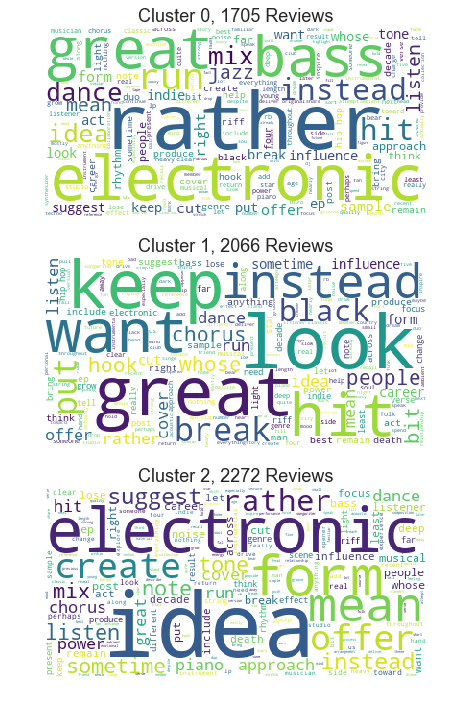

In [159]:
# plots clusters as wordclouds
x=1
plt.figure(figsize=(10,12))
for i in range(3):
    plt.subplot(3,1,x)
    plot_label('labels_1', i)
    x+=1

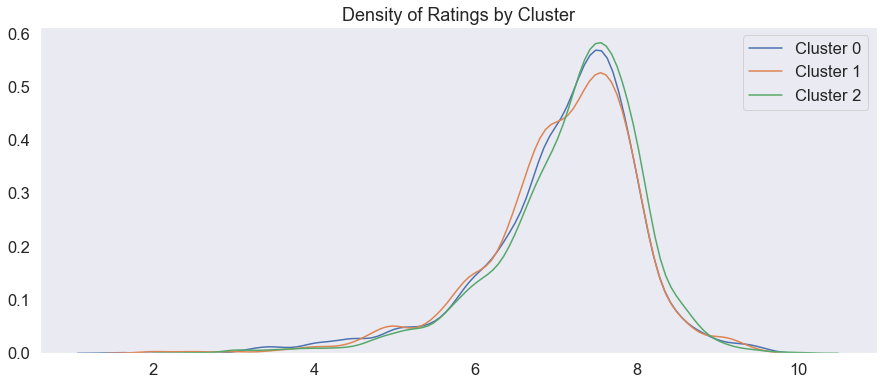

In [152]:
# plots distribution of ratings by cluster
plt.figure(figsize=(15,6))
plt.title('Density of Ratings by Cluster')
for i in range(4):
    sns.kdeplot(music_df[music_df['labels_1']==i]['rating'], label='Cluster '+str(i))

In [153]:
# 6 clusters
labels_2 = KMeans(n_clusters=6, random_state=414).fit_predict(d2v_model.docvecs.vectors_docs)
print(metrics.silhouette_score(d2v_model.docvecs.vectors_docs, labels_2, metric='cosine'))
print(Counter(labels_2))

0.10855899
Counter({0: 1231, 3: 1177, 5: 1117, 1: 947, 2: 886, 4: 685})


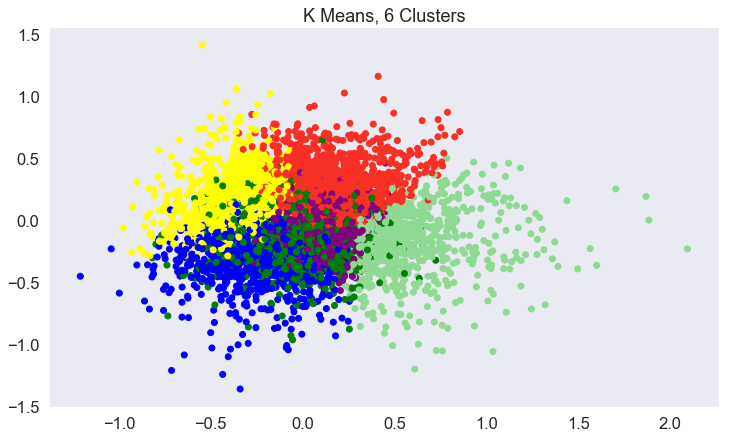

In [154]:
plt.figure(figsize=(12,7))
label2 = ['#FFFF00', '#008000', '#0000FF', '#800080', '#8FDA92', '#F82F25']
color2 = [label2[i] for i in labels_2]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color2)
plt.title('K Means, 6 Clusters')
plt.show()

In [155]:
# adds labels to dataframe
music_df['labels_2'] = labels_2

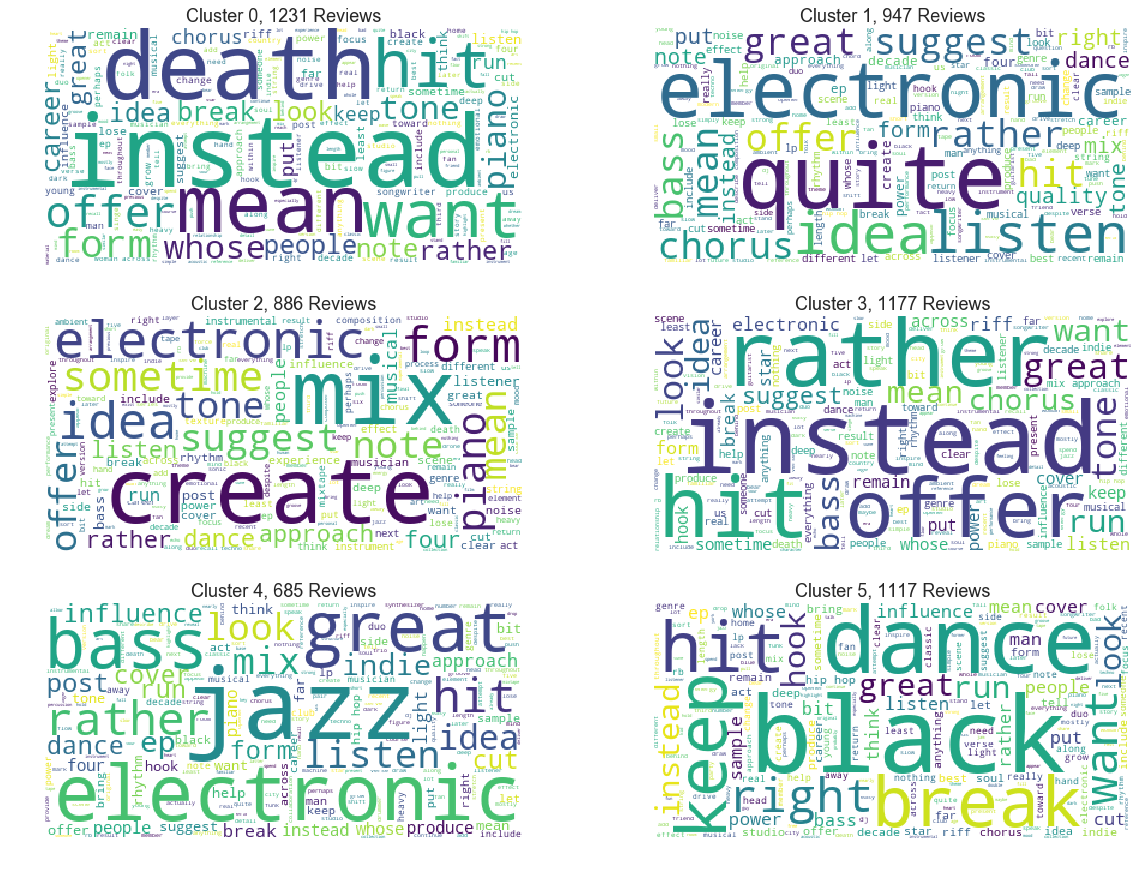

In [157]:
# plots clusters as wordclouds
x=1
plt.figure(figsize=(20,15))
for i in range(6):
    plt.subplot(3,2,x)
    plot_label('labels_2', i)
    x+=1

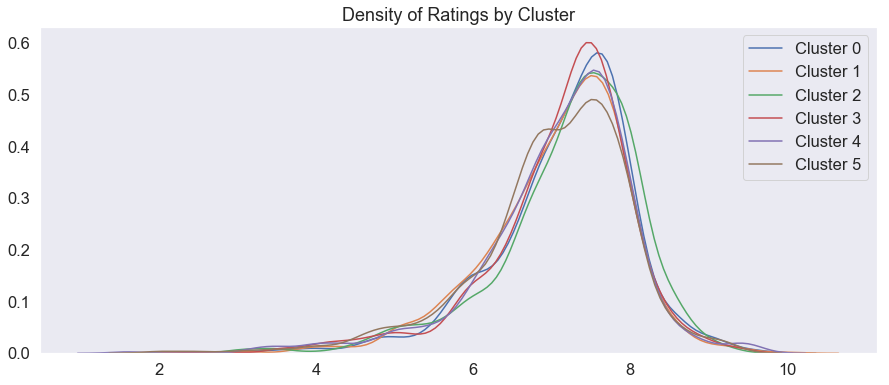

In [158]:
# plots distribution of ratings by cluster
plt.figure(figsize=(15,6))
plt.title('Density of Ratings by Cluster')
for i in range(10):
    sns.kdeplot(music_df[music_df['labels_2']==i]['rating'], label='Cluster '+str(i))

### Observations
- The Doc2vec features with K Means returned clusters that do not appear genre-specific. 
- The distribution of ratings across clusters are also similar.
- This features set and model may be more susceptible to noise, or might be clustering on writing style or another element that is not labeled.

## Making Recommendations with Doc2Vec

In [187]:
# defines function to return 3 similar albums
def recommend_2(artist_album):
    print('Here are 3 albums similar to ' + artist_album + ':')
    recs = d2v_model.docvecs.most_similar(artist_album)[:3]
    x = 1
    for rec in recs: 
        print('\n' + str(x) + '. ' + get_info(rec[0]) + ' (score:' +      str(rec[1]) + ')')
        x+=1

In [189]:
# tests recommender
recommend_2('Beyoncé, Lemonade')

Here are 3 albums similar to Beyoncé, Lemonade:

1. Teen Daze, Morning World -- Teen Daze's earliest work was lumped in with chillwave, but through releases like All of Us Together, the rhythms started to become the focal point of his productions. Frontman Jamison's singing is the center point of Morning World, and it sounds like nothing else in his catalog.
 (score:0.8353366851806641)

2. tofubeats, Fantasy Club -- Channelling Southern rap, house music, and lush orchestral pop, the third release from Yusuke Kawai as tofubeats is one of the best J-Pop releases of the year.
 (score:0.8069868087768555)

3. Juju & Jordash, Clean-Cut -- The Amsterdam-based duo of Gal Aner and Jordan Czamanski are a pair of pot-smoking former jazzbos known for long, improvisational synth-and-drum-machine jams that wobble on the edge between late-night abandon and psychedelic freak-out. On their inspired new album, they sound tighter and more focused than ever.
 (score:0.8005099296569824)


In [190]:
recommend_2('Esperanza Spalding, Emily’s D+Evolution')

Here are 3 albums similar to Esperanza Spalding, Emily’s D+Evolution:

1. TisaKorean, A Guide To Being A Partying Freshman -- With its tinny mix, infectious chant raps, and Fruity Loops-style beats, this Texas dance rap king's debut has a refreshingly unforced charm.
 (score:0.8923813104629517)

2. Eli Keszler, Stadium -- Inspired by a move into Manhattan, the adventurous drummer fuses worlds of avant-jazz and electronica in a dozen restrained pieces that feel like streetscape scores.
 (score:0.8752336502075195)

3. Lil Xan, Total Xanarchy -- On his debut album, the standard-bearer of the sad-rap movement refuses to reveal much in the way of emotion at all, aside from a kind of sullen, conflicted defiance.
 (score:0.8711211681365967)


In [191]:
recommend_2('Leif Vollebekk, New Ways')

Here are 3 albums similar to Leif Vollebekk, New Ways:

1. Thaiboy Digital, Legendary Member -- The Thailand-born and Sweden-raised rapper offers a dreamy, melancholic, and abstracted take on mumble rap.
 (score:0.9179404973983765)

2. Caribou, Suddenly -- Dan Snaith’s latest is as sly and layered as ever, but he finds ways to be more direct with his songwriting. There are no bum notes, no wasted motions, no corners of the audio spectrum left untouched. 
 (score:0.9068988561630249)

3. Foals, Everything Not Saved Will Be Lost Part 2 -- The English band’s second album this year isn’t a complement to its predecessor so much as just another iteration on a now-standard formula.
 (score:0.89837646484375)


### **Observations**
- The Doc2Vec recommender makes suggestions across genres. 
- Similarity scores for the sample albums are higher than in the previous recommender.
- It is possible this model is picking up on writing styles and/or content. For example, the reviews for Leif Vollebekk's *New Ways* and Thaiboy Digital's *Legendary Member* (0.91 similarity score) both discuss themes of relocation and melancholy.
- Ultimately, the first recommendation model seems to perform better. The three recommended albums are intuitively related to the inputs and to each other. 

# Sentiment Analysis with Rating

## Defining a Target

In [193]:
music_df['rating'].describe()

count    6043.000000
mean        7.123184
std         0.933552
min         1.600000
25%         6.700000
50%         7.300000
75%         7.700000
max        10.000000
Name: rating, dtype: float64

In [ ]:
# creates a binary variable for reviews above/below median
conditions = [
    (music_df['rating'] > 7.3),
    (music_df['rating'] <= 7.3)]
choices = ['positive', 'negative']
music_df['overall_sentiment'] = np.select(conditions, choices)

In [574]:
music_df.sample(4)

abstract  \
645   The Brooklyn band's explosively verbal, shapes...   
4415  100% Juice opens with the clearest mission sta...   
2685  In a genre known for singles, Kingston’s Jamar...   
2683  Led by singer Alex Menne, the Seattle band arr...   

                                                  album         artist  \
645   I Spent the Winter Writing Songs About Getting...        Proper.   
4415                                         100% Juice        Juicy J   
2685                                         Chronology       Chronixx   
2683                                      Plastic Cough  Great Grandpa   

           date                                          editorial   genre  \
645  2019-08-17  When Erik Garlington changed his band’s name f...    Rock   
4415 2015-09-25  We’re often told rap is a young person’s game,...     Rap   
2685 2017-07-11  In the fall of 2011, live music bubbled up in ...  Global   
2683 2017-07-12  Alex Menne knows her enemies: entitled dudes, ...    Rock   

      rating                                                url  year  \
645      7.4  /reviews/albums/proper-i-spent-the-winter-writ...  2019   
4415     7.1                   /reviews/albums/21076-100-juice/  2015   
2685     7.6               /reviews/albums/chronixx-chronology/  2017   
2683     6.7       /reviews/albums/great-grandpa-plastic-cough/  2017   

                                               all_text  \
645   brooklyn bands explosively verbal shapeshifte ...   
4415  clear mission statement possible stupid ass sh...   
2685  genre kingston jamar mcnaughton offer complete...   
2683  alex menne seattle arrive solid anxious bubble...   

                                             doc_labels  labels_1  labels_2  \
645   Proper., I Spent the Winter Writing Songs Abou...         2         0   
4415                                Juicy J, 100% Juice         0         4   
2685                               Chronixx, Chronology         1         5   
2683                       Great Grandpa, Plastic Cough         0         1   

     overall_sentiment  
645           positive  
4415          negative  
2685          positive  
2683          negative

In [288]:
music_df['overall_sentiment'].value_counts()

negative    3202
positive    2841
Name: overall_sentiment, dtype: int64

## Preparing Feature Sets
I'll test three feature sets below: Bag of Words, TF-IDF, and Word2Vec.

In [290]:
# bag of words-- unigrams and bigrams, min frequency 3
vectorizer = CountVectorizer(analyzer='word', min_df=3, ngram_range=(1,2))
X = vectorizer.fit_transform(music_df['all_text'])
bag = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
bow_df = pd.concat([bag, music_df[['doc_labels', 'overall_sentiment']]], axis=1)
bow_df.head()

aa  aacm  aah  aaliyah  aand  aap  aap board  aap ferg  aap fergs  aap mob  \
0   0     0    0        0     0    0          0         0          0        0   
1   0     0    0        0     0    0          0         0          0        0   
2   0     0    0        0     0    0          0         0          0        0   
3   0     0    0        0     0    0          0         0          0        0   
4   0     0    0        0     0    0          0         0          0        0   

   ...  zulu  zum  zutrau  zvuk  zwan  zydeco  zz  zz top  \
0  ...     0    0       0     0     0       0   0       0   
1  ...     0    0       0     0     0       0   0       0   
2  ...     0    0       0     0     0       0   0       0   
3  ...     0    0       0     0     0       0   0       0   
4  ...     0    0       0     0     0       0   0       0   

                      doc_labels  overall_sentiment  
0       KeiyaA, Forever, Ya Girl           positive  
1   dvsn, A Muse in Her Feelings           negative  
2           Duke Dumont, Duality           negative  
3                Serengeti, Ajai           positive  
4  Westside Gunn, Pray For Paris           positive  

[5 rows x 78127 columns]

In [289]:
# tfidf-- unigrams and bigrams, min frequency 5
tfidf_df2 = pd.concat([music_df[['doc_labels', 'overall_sentiment']], 
                    tfidf_df.drop(['artist', 'album', 'all_text', 'rating',
                                   'genre'], axis=1)], axis=1)
tfidf_df2.head()

doc_labels overall_sentiment   aa  aacm  aaliyah  aap  \
0       KeiyaA, Forever, Ya Girl          positive  0.0   0.0      0.0  0.0   
1   dvsn, A Muse in Her Feelings          negative  0.0   0.0      0.0  0.0   
2           Duke Dumont, Duality          negative  0.0   0.0      0.0  0.0   
3                Serengeti, Ajai          positive  0.0   0.0      0.0  0.0   
4  Westside Gunn, Pray For Paris          positive  0.0   0.0      0.0  0.0   

   aap ferg  aap mob  aap rocky  aap rockys  ...  zonked  zoo  zoom  \
0       0.0      0.0        0.0         0.0  ...     0.0  0.0   0.0   
1       0.0      0.0        0.0         0.0  ...     0.0  0.0   0.0   
2       0.0      0.0        0.0         0.0  ...     0.0  0.0   0.0   
3       0.0      0.0        0.0         0.0  ...     0.0  0.0   0.0   
4       0.0      0.0        0.0         0.0  ...     0.0  0.0   0.0   

   zoom further  zoomed  zorn  zorns   zs   zz  zz top  
0           0.0     0.0   0.0    0.0  0.0  0.0     0.0  
1           0.0     0.0   0.0    0.0  0.0  0.0     0.0  
2           0.0     0.0   0.0    0.0  0.0  0.0     0.0  
3           0.0     0.0   0.0    0.0  0.0  0.0     0.0  
4           0.0     0.0   0.0    0.0  0.0  0.0     0.0  

[5 rows x 36957 columns]

In [291]:
# word2vec-- 200 vectors
model = gensim.models.Word2Vec(
    music_df['all_text'],
    workers=5,
    min_count=3,
    window=4,
    sg=0,
    sample=1e-3,
    size=200,
    hs=1
)

word2vec_arr = np.zeros((music_df.shape[0],200))

for i, text in enumerate(music_df['all_text']):
    word2vec_arr[i,:] = np.mean([model[lemma] for lemma in text], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
w2v_df = pd.concat([music_df[['doc_labels', 'overall_sentiment']], word2vec_arr], axis=1)

w2v_df.dropna(inplace=True)
w2v_df.head()

/Users/ellenpaigehoffman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


doc_labels overall_sentiment         0         1  \
0       KeiyaA, Forever, Ya Girl          positive -0.127665 -0.042885   
1   dvsn, A Muse in Her Feelings          negative -0.137367 -0.054997   
2           Duke Dumont, Duality          negative -0.137572 -0.050732   
3                Serengeti, Ajai          positive -0.132163 -0.049990   
4  Westside Gunn, Pray For Paris          positive -0.118251 -0.043434   

          2         3         4         5         6         7  ...       190  \
0 -0.026420  0.068495  0.005205  0.060952  0.089373 -0.017051  ... -0.027738   
1 -0.039403  0.063404 -0.003385  0.051368  0.081526 -0.008173  ... -0.024143   
2 -0.032293  0.072464  0.001805  0.053514  0.090813 -0.003298  ... -0.024850   
3 -0.029561  0.071070  0.000840  0.050550  0.086770 -0.013558  ... -0.023531   
4 -0.037269  0.059414 -0.012191  0.038796  0.080615  0.000952  ... -0.025233   

        191       192       193       194       195       196       197  \
0  0.026122  0.004436 -0.013403 -0.023019 -0.051474 -0.079264 -0.104533   
1  0.025589  0.011007 -0.015371 -0.021245 -0.044968 -0.077937 -0.101234   
2  0.025392  0.014411 -0.010739 -0.019142 -0.046616 -0.073984 -0.099537   
3  0.024698  0.013392 -0.007432 -0.017509 -0.045923 -0.078809 -0.105159   
4  0.023402  0.019755 -0.009187 -0.021319 -0.038315 -0.073493 -0.097160   

        198       199  
0  0.055452  0.015508  
1  0.056030  0.016501  
2  0.051867  0.012120  
3  0.057054  0.019201  
4  0.052353  0.018043  

[5 rows x 202 columns]

In [297]:
# defines a target and feature set for the three dataframes above
y1 = bow_df['overall_sentiment']
X1 = np.array(bow_df.drop(['doc_labels', 'overall_sentiment'], 1))

y2 = tfidf_df2['overall_sentiment']
X2 = np.array(tfidf_df2.drop(['doc_labels', 'overall_sentiment'], 1))

y3 = w2v_df['overall_sentiment']
X3 = np.array(w2v_df.drop(['doc_labels', 'overall_sentiment'], 1))

In [298]:
# splits into train and test sets
X_train1, X_test1, y_train1, y_test1, = train_test_split(X1, y1, test_size=0.33, random_state=41)
X_train2, X_test2, y_train2, y_test2, = train_test_split(X2, y2, test_size=0.33, random_state=41)
X_train3, X_test3, y_train3, y_test3, = train_test_split(X3, y3, test_size=0.33, random_state=41)

## Models

### Logistic Regression

In [300]:
# lbfgs solver, L2 penalty
lr_lbfgs = LogisticRegression(penalty= 'l2', solver='lbfgs', max_iter=300)

lr_1 = cross_val_score(lr_lbfgs, X1, y1, cv=5)
lr_2 = cross_val_score(lr_lbfgs, X2, y2, cv=5)
lr_3 = cross_val_score(lr_lbfgs, X3, y3, cv=5)

print("----------------------Logistic Regression (lbfgs, L2 penalty) / BoW Scores----------------------")
print(lr_1)

print("\n----------------------Logistic Regression (lbfgs, L2 penalty) / TF-IDF Scores----------------------")
print(lr_2)

print("\n----------------------Logistic Regression (lbfgs, L2 penalty) / Word2Vec Scores----------------------")
print(lr_3)

----------------------Logistic Regression (lbfgs, L2 penalty) / BoW Scores----------------------
[0.68016529 0.71381307 0.72433775 0.66639073 0.70115894]

----------------------Logistic Regression (lbfgs, L2 penalty) / TF-IDF Scores----------------------
[0.72809917 0.74441687 0.73178808 0.70115894 0.68211921]

----------------------Logistic Regression (lbfgs, L2 penalty) / Word2Vec Scores----------------------
[0.53553719 0.55417701 0.53476821 0.54304636 0.5339404 ]


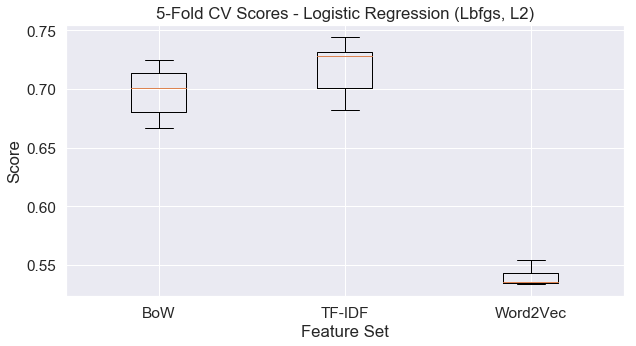

In [310]:
sns.set(style='darkgrid', font_scale=1.4)

plt.figure(figsize=(10,5))
plt.boxplot([lr_1, lr_2, lr_3], labels=['BoW', 'TF-IDF', 'Word2Vec'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Logistic Regression (Lbfgs, L2)');

In [307]:
# liblinear solver, L1 penalty
lr_liblin = LogisticRegression(penalty= 'l1', solver='liblinear', max_iter=500)

lr_4 = cross_val_score(lr_liblin, X1, y1, cv=5)
lr_5 = cross_val_score(lr_liblin, X2, y2, cv=5)
lr_6 = cross_val_score(lr_liblin, X3, y3, cv=5)

print("----------------------Logistic Regression (liblinear, L1 penalty) / BoW Scores----------------------")
print(lr_4)

print("\n----------------------Logistic Regression (liblinear, L1 penalty) / TF-IDF Scores----------------------")
print(lr_5)

print("\n----------------------Logistic Regression (liblinear, L1 penalty) / Word2Vec Scores----------------------")
print(lr_6)

----------------------Logistic Regression (liblinear, L1 penalty) / BoW Scores----------------------
[0.66694215 0.69892473 0.70281457 0.66059603 0.65645695]

----------------------Logistic Regression (liblinear, L1 penalty) / TF-IDF Scores----------------------
[0.66694215 0.66501241 0.67218543 0.64817881 0.65976821]

----------------------Logistic Regression (liblinear, L1 penalty) / Word2Vec Scores----------------------
[0.52809917 0.53019024 0.52980132 0.52980132 0.53311258]


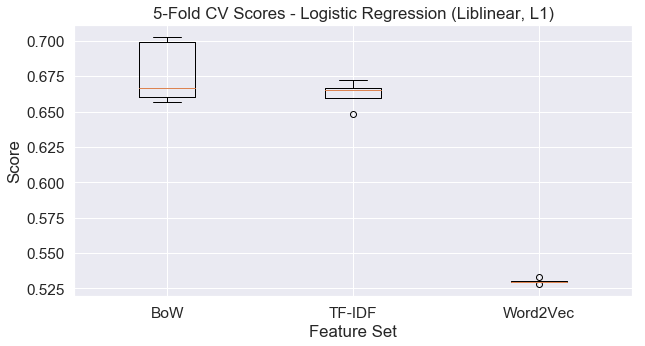

In [309]:
plt.figure(figsize=(10,5))
plt.boxplot([lr_4, lr_5, lr_6], labels=['BoW', 'TF-IDF', 'Word2Vec'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Logistic Regression (Liblinear, L1)');

**Observations:**
- The lbfgs solver with L2 penalty applied to the TF-IDF feature set performed best across five folds. Average accuracy is about 72%, with scores ranging from 68-74%. 
- The Word2Vec features performed worst in both of the logistic regression models, with average accuracy below 60%. This corpus may not be big enough to take advantage of it.

I'll explore performance of the highest-performing model further below.

In [368]:
# fits model to the TF-IDF features
lr_lbfgs.fit(X_train2, y_train2)
y_pred = lr_lbfgs.predict(X_test2)

In [369]:
print(metrics.classification_report(y_test2, y_pred, 
                                    target_names=tfidf_df2['overall_sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.71      0.77      0.74      1064
    negative       0.71      0.64      0.67       931

    accuracy                           0.71      1995
   macro avg       0.71      0.71      0.71      1995
weighted avg       0.71      0.71      0.71      1995



In [370]:
# creates list of coefficients
coefs = lr_lbfgs.coef_
coefs = coefs.tolist()[0]

# creates list of features
features = tfidf_df2.drop(['doc_labels', 'overall_sentiment'], 1).columns.tolist()

# creates dataframe
lrcoefs_df = pd.DataFrame(features, columns =['words'])
lrcoefs_df['coefficients'] = coefs

In [371]:
# these words are correlated with high ratings
lrcoefs_df.sort_values(by='coefficients', ascending=False).head(20)

words  coefficients
16699         jazz      2.132329
7596         death      1.488778
3072         black      1.463232
32714       techno      1.208808
24126      perfect      1.184951
7731          deep      1.178423
27634       rhythm      1.139628
25107        power      1.120336
13369     gorgeous      1.113418
16129   instrument      1.076443
14543      herself      1.047301
4944        chasny      1.038226
34563  underground      1.024112
8149        detail      0.988460
15109        human      0.984926
12534       friend      0.982425
8918          doom      0.978265
12464      freedom      0.965721
11176       family      0.961469
23308          our      0.944527

In [372]:
# these words are correlated with low ratings
lrcoefs_df.sort_values(by='coefficients').head(20)

words  coefficients
21767            not     -2.342278
17598           lack     -2.272812
1881         attempt     -1.644828
2185             bad     -1.570312
16234    interesting     -1.544042
25469        problem     -1.386827
2864            best     -1.356599
17930          least     -1.334027
9771         electro     -1.329289
34699  unfortunately     -1.248955
3029             bit     -1.138767
1439          appeal     -1.136978
23296      otherwise     -1.126125
24717       pleasant     -1.125127
21525           nice     -1.078764
11063           fail     -1.055596
15062        however     -0.952989
14683            hit     -0.940526
22360      not quite     -0.938346
4923           charm     -0.936994

In [373]:
# these features had a small or no impact on the model
lrcoefs_df[(lrcoefs_df['coefficients'] > -0.01) &
          (lrcoefs_df['coefficients'] < 0.01)]

words  coefficients
9      aaron bryce      0.003968
11     aaron maine     -0.006219
19           abate     -0.007248
29        aberrant      0.008724
41     ability not     -0.001859
...            ...           ...
36925       zinger      0.006747
36930       zipper      0.006012
36933           zo      0.005072
36952           zs     -0.000682
36953           zz     -0.002839

[3258 rows x 2 columns]

**Observations:** 
- While precision is equal for positive and negative instances, recall is 13 points higher for positive reviews. 
- The model relies heavily on unigrams.
- Among features with the highest positive/negative correlations, some are intuitive (i.e. 'perfect' and 'bad'), while others may be picking up on other trends in the dataset (i.e. Jazz albums have the highest average rating).

I'll hone the feature set and see if changes improve performance. 

In [376]:
# creates list of features to drop
drop_list = lrcoefs_df[(lrcoefs_df['coefficients'] > -0.01) &
                       (lrcoefs_df['coefficients'] < 0.01)]['words'].to_list()

drop_list += ['jazz', 'death', 'black', 'techno', 'rhythm', 'instrument', 'herself',
              'chasny', 'underground', 'doom', 'family', 'our', 'not', 'electro', 'bit',
              'otherwise', 'however', 'hit', 'charm', 'rb', 'electronic', 'global', 
              'experimental', 'folk', 'country']

# stores features in a new dataframe
tfidf_df3 = tfidf_df2.drop(columns=drop_list, axis=1)
tfidf_df3.shape

(6043, 33674)

In [377]:
y4 = tfidf_df3['overall_sentiment']
X4 = np.array(tfidf_df3.drop(['doc_labels', 'overall_sentiment'], 1))

X_train4, X_test4, y_train4, y_test4, = train_test_split(X4, y4, test_size=0.33, random_state=41)

In [378]:
# applies model across 5 folds
lr_7 = cross_val_score(lr_lbfgs, X4, y4, cv=5)

print("----------------------Logistic Regression (lbfgs, L2 penalty) / Updated TF-IDF Scores----------------------")
print(lr_7)

----------------------Logistic Regression (lbfgs, L2 penalty) / Updated TF-IDF Scores----------------------
[0.72644628 0.75268817 0.7442053  0.69784768 0.68708609]


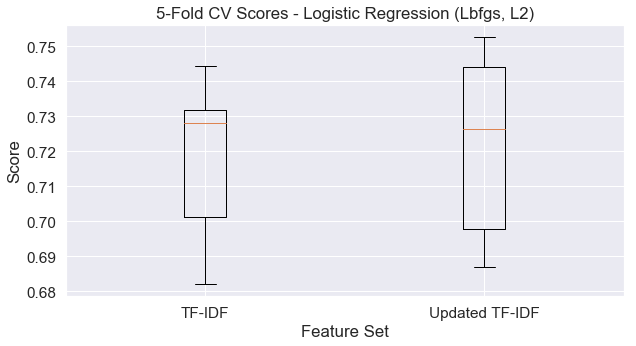

In [379]:
plt.figure(figsize=(10,5))
plt.boxplot([lr_2, lr_7], labels=['TF-IDF', 'Updated TF-IDF'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Logistic Regression (Lbfgs, L2)');

In [380]:
# fits and evaluates model on revised feature set
lr_lbfgs.fit(X_train4, y_train4)
y_pred = lr_lbfgs.predict(X_test4)

In [381]:
print(metrics.classification_report(y_test4, y_pred, 
                                    target_names=tfidf_df3['overall_sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.72      0.78      0.74      1064
    negative       0.72      0.65      0.68       931

    accuracy                           0.72      1995
   macro avg       0.72      0.71      0.71      1995
weighted avg       0.72      0.72      0.72      1995



In [382]:
# stores new coefficients in a dataframe
coefs2 = lr_lbfgs.coef_
coefs2 = coefs2.tolist()[0]
features2 = tfidf_df3.drop(['doc_labels', 'overall_sentiment'], 1).columns.tolist()

lrcoefs_df2 = pd.DataFrame(features2, columns =['words'])
lrcoefs_df2['coefficients'] = coefs2

In [383]:
# these words are correlated with high ratings
lrcoefs_df2.sort_values(by='coefficients', ascending=False).head(15)

words  coefficients
7074       deep      1.212869
21965   perfect      1.146338
12199  gorgeous      1.139325
22875     power      1.127360
7459     detail      0.999382
13762     human      0.998444
11426    friend      0.983360
11365   freedom      0.970398
11052  footwork      0.951029
11122      form      0.940356
23209   process      0.920988
11344      free      0.917706
19112   musical      0.913964
8532     dupuis      0.908788
20612      note      0.900842

In [384]:
# these words are correlated with low ratings
lrcoefs_df2.sort_values(by='coefficients').head(15)

words  coefficients
16025           lack     -2.325838
1696         attempt     -1.681475
1974             bad     -1.645169
14775    interesting     -1.591252
23202        problem     -1.412017
2600            best     -1.383329
16335          least     -1.361423
31612  unfortunately     -1.276818
1296          appeal     -1.199165
22510       pleasant     -1.160215
19622           nice     -1.113283
10089           fail     -1.084181
20371      not quite     -1.071049
23806          quite     -1.027777
27739      somewhere     -0.939893

**Observations:** 
- Overall accuracy improved by 1pt with the revised feature set. Unfortunately, the model continues to recall more positive than negative reviews. 

I'll model sentiment with a Random Forest classifier below and compare results.

### Random Forest

In [336]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)

rfc_1 = cross_val_score(rfc, X1, y1, cv=5)
rfc_2 = cross_val_score(rfc, X2, y2, cv=5)
rfc_3 = cross_val_score(rfc, X3, y3, cv=5)


print("----------------------Random Forest / BoW Scores----------------------")
print(rfc_1)

print("\n----------------------Random Forest / TF-IDF Scores----------------------")
print(rfc_2)

print("\n----------------------Random Forest / Word2Vec Scores----------------------")
print(rfc_3)

----------------------Random Forest / BoW Scores----------------------
[0.6338843  0.61538462 0.6307947  0.6134106  0.61175497]

----------------------Random Forest / TF-IDF Scores----------------------
[0.62396694 0.64019851 0.63907285 0.61506623 0.6134106 ]

----------------------Random Forest / Word2Vec Scores----------------------
[0.54876033 0.56741108 0.57119205 0.55629139 0.53725166]


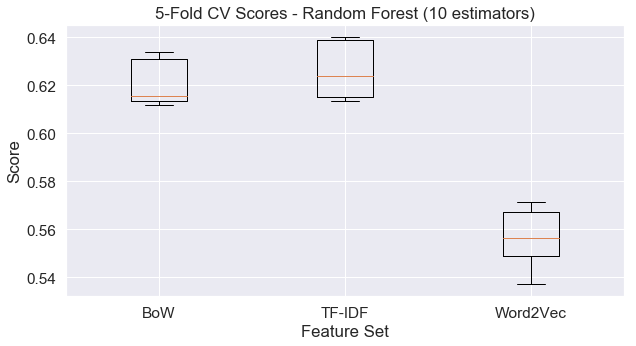

In [337]:
plt.figure(figsize=(10,5))
plt.boxplot([rfc_1, rfc_2, rfc_3], labels=['BoW', 'TF-IDF', 'Word2Vec'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Random Forest (10 estimators)');

In [338]:
# increasing estimators and min leaf
rfc50 = ensemble.RandomForestClassifier(n_estimators=50, min_samples_leaf=50)

rfc_4 = cross_val_score(rfc50, X1, y1, cv=5)
rfc_5 = cross_val_score(rfc50, X2, y2, cv=5)
rfc_6 = cross_val_score(rfc50, X3, y3, cv=5)


print("----------------------Random Forest (50 esimators) / BoW Scores----------------------")
print(rfc_4)

print("\n----------------------Random Forest (50 esimators) / TF-IDF Scores----------------------")
print(rfc_5)

print("\n----------------------Random Forest (50 esimators) / Word2Vec Scores----------------------")
print(rfc_6)

----------------------Random Forest (50 esimators) / BoW Scores----------------------
[0.63471074 0.62696443 0.64569536 0.62582781 0.60430464]

----------------------Random Forest (50 esimators) / TF-IDF Scores----------------------
[0.65867769 0.64598842 0.68211921 0.64321192 0.64486755]

----------------------Random Forest (50 esimators) / Word2Vec Scores----------------------
[0.57190083 0.60049628 0.56539735 0.57450331 0.5397351 ]


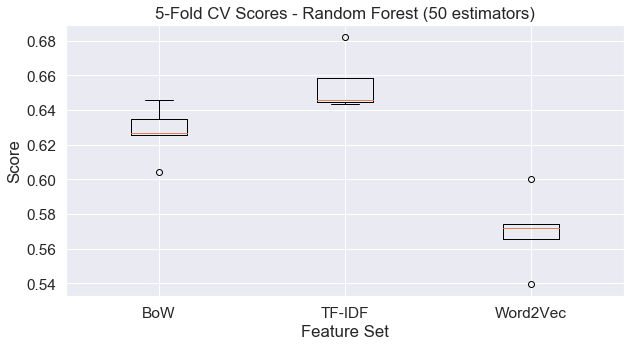

In [339]:
plt.figure(figsize=(10,5))
plt.boxplot([rfc_4, rfc_5, rfc_6], labels=['BoW', 'TF-IDF', 'Word2Vec'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Random Forest (50 estimators)');

**Observations:**
- The RFC models above are not as effective as the logistic regression model; average accuracy does not exceed 70%.
- While accuracy increases with additional estimators (10 to 50), so does overfitting, and the boxplots above show outlier scores. 
- Again, the Word2Vec feature sets performed worst.

I'll explore and try to improve the performance of the RFC model with 50 classifiers on the TF-IDF feature set.

In [394]:
# fits the model to tf-idf dataframe
rfc50.fit(X_train2, y_train2)
y_pred = rfc50.predict(X_test2)

In [395]:
print(metrics.classification_report(y_test2, y_pred, 
                                    target_names=tfidf_df2['overall_sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.63      0.85      0.73      1064
    negative       0.72      0.43      0.54       931

    accuracy                           0.66      1995
   macro avg       0.68      0.64      0.63      1995
weighted avg       0.67      0.66      0.64      1995



In [396]:
# stores feature importances
impts = rfc50.feature_importances_

# stores list of features
feats = tfidf_df2.drop(['doc_labels', 'overall_sentiment'], 1).columns.tolist()

# stores in dataframe
rfc_impts = pd.DataFrame(feats, columns = ['features'])
rfc_impts['importance'] = impts

In [397]:
# these features are most important
rfc_impts.sort_values(by='importance', ascending=False).head(25)

features  importance
17598           lack    0.025523
21767            not    0.015701
16699           jazz    0.013496
2864            best    0.012358
1881         attempt    0.011518
29160          shape    0.010543
34699  unfortunately    0.009969
14683            hit    0.008317
2185             bad    0.007754
3029             bit    0.007685
33559           tone    0.007602
14622        himself    0.006753
8113         despite    0.006731
9177           drone    0.006621
32894        tension    0.006330
12203           form    0.006315
28587          scene    0.006225
16129     instrument    0.005970
26493             rb    0.005877
35749           want    0.005765
25276        present    0.005704
31513          story    0.005679
17930          least    0.005653
7731            deep    0.005575
25477        process    0.005514

In [398]:
# these features did not impact the model
rfc_impts[rfc_impts['importance'] == 0]

features  importance
0            aa         0.0
1          aacm         0.0
2       aaliyah         0.0
3           aap         0.0
4      aap ferg         0.0
...         ...         ...
36950      zorn         0.0
36951     zorns         0.0
36952        zs         0.0
36953        zz         0.0
36954    zz top         0.0

[36355 rows x 2 columns]

In [399]:
tfidf_df2.shape[1] - 36355

602

**Observations:**
- Like the LR model, the RFC model has higher recall for positive reviews. Here, the gap is much bigger, by 42pts.
- The RFC model is also more precise in identifying negative reviews, by 9pts.
- Of 36,957 features, this model only used 602 unigrams/bigrams. The word with the highest importance is 'lack', 0.03.

In [403]:
# drops features with 0 importance, genre, and a few keywords from above
drop_list2 = rfc_impts[rfc_impts['importance'] == 0]['features'].to_list()
drop_list2 += ['jazz', 'rb', 'electronic', 'global', 'experimental', 'folk',
               'country', 'not', 'shape', 'best']
tfidf_df5 = tfidf_df2.drop(columns=drop_list2, axis=1)
tfidf_df5.shape

(6043, 594)

In [404]:
# prepares new feature set for modeling
y5 = tfidf_df5['overall_sentiment']
X5 = np.array(tfidf_df5.drop(['doc_labels', 'overall_sentiment'], 1))
X_train5, X_test5, y_train5, y_test5, = train_test_split(X5, y5, test_size=0.33, random_state=41)

In [405]:
rfc_7 = cross_val_score(rfc50, X5, y5, cv=5)

print("----------------------Random Forest / Updated TF-IDF Scores----------------------")
print(rfc_7)

----------------------Random Forest / Updated TF-IDF Scores----------------------
[0.66942149 0.65425972 0.66804636 0.64652318 0.63410596]


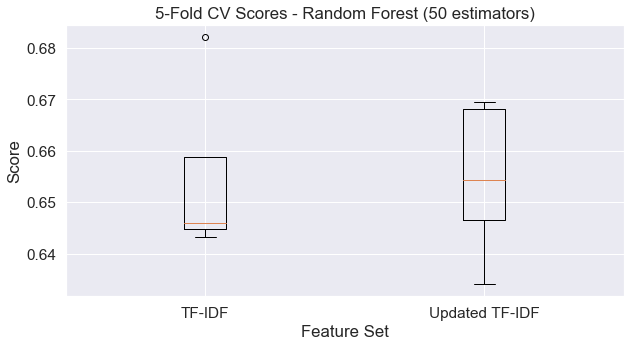

In [406]:
plt.figure(figsize=(10,5))
plt.boxplot([rfc_5, rfc_7], labels=['TF-IDF', 'Updated TF-IDF'])
plt.ylabel('Score')
plt.xlabel('Feature Set')
plt.title('5-Fold CV Scores - Random Forest (50 estimators)');

In [407]:
# fits model to new feature set
rfc50.fit(X_train5, y_train5)
y_pred = rfc50.predict(X_test5)

In [408]:
print(metrics.classification_report(y_test5, y_pred, 
                                    target_names=tfidf_df5['overall_sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.65      0.78      0.71      1064
    negative       0.68      0.53      0.60       931

    accuracy                           0.66      1995
   macro avg       0.67      0.65      0.65      1995
weighted avg       0.67      0.66      0.66      1995



In [409]:
# stores feature importances
impts2 = rfc50.feature_importances_
# feats = feats.tolist()[0]

# stores list of features
feats2 = tfidf_df5.drop(['doc_labels', 'overall_sentiment'], 1).columns.tolist()

# stores in dataframe
rfc_impts2 = pd.DataFrame(feats2, columns = ['features'])
rfc_impts2['importance'] = impts2

In [410]:
# these features are most important
rfc_impts2.sort_values(by='importance', ascending=False).head(15)

features  importance
279           lack    0.042305
37             bad    0.026080
32         attempt    0.025220
271    interesting    0.021870
249            hit    0.018798
348      otherwise    0.017528
227       gorgeous    0.016776
128           deep    0.015254
147          drone    0.014689
284          least    0.014330
268     instrument    0.013441
25        anything    0.012246
561  unfortunately    0.011845
126          death    0.011390
26          appeal    0.011075

**Observations:**
- Overall accuracy is about the same after honing the feature set (66%). The RFC model still does not perform as well as the LR model above. 
- Overfitting across five folds decreased with the updated feature set.
- The gap between performance on positive and negative reviews also decreased.

As the LR model proved more reliable in determining sentiment, I'll use the features in that model to identify highlight (positive) sentences in positive reviews. In addition to suggesting similar music, Pitchfork can encourage readers to click on recommendations with high reviews by adding a highlight sentence.

# Identifying Review Highlights
I'll create a rule-based function using the features with positive coefficients from the LR model to find positive sentences within reviews.

In [447]:
# stores features with a positive coefficient in a list, ordered by coefficient
positive_words = lrcoefs_df2[lrcoefs_df2['coefficients'] > 0.05].sort_values(
    by='coefficients', ascending=False)['words'].tolist()

In [550]:
# defines function to print a highlight sentence, given a review
def find_highlight(artist_album):
    i = music_df[music_df['doc_labels'] == artist_album].index[0]
    ed_text =  music_df.loc[i, 'editorial']
    ed_sents = tokenize.sent_tokenize(ed_text)
    highlight = 0
    for word in positive_words: # searches for words with higher coefficients first
        for sent in ed_sents:
            if highlight is 0:
                if word in sent:
                    highlight = sent
                    return(str(sent))

In [609]:
# tests the function on samples with various ratings
print(find_highlight('Eminem, Kamikaze'))
print(music_df.loc[1561, 'rating'])

Ditch the new songs with their schtick and it’d be a perfect late-career highlight to include in a Super Bowl halftime show we might one day endure or a Las Vegas residency he might one day settle for.
5.0


In [611]:
print(find_highlight('Yo Gotti, The Art of Hustle'))
print(music_df.loc[4084, 'rating'])

Yo Gotti has been a Memphis rap star for so long that you can hear his voice deepening over the years even as his subject matter hasn't.
6.6


In [610]:
print(find_highlight('Quarterbacks, Quarterbacks'))
print(music_df.loc[5058, 'rating'])

Engle has found the perfect vehicle for this kind of subject matter, which is twee-punk in its purest form.
7.0


In [601]:
print(find_highlight('Keith Jarrett, Munich 2016'))
print(music_df.loc[270, 'rating'])

Jarrett’s improvisational solo concerts have been characterized by this level of physicality since he began performing professionally in the 1960s, and more than half a century hasn’t hampered his game.
7.9


In [594]:
print(find_highlight('Serengeti, Ajai'))
print(music_df.loc[3, 'rating'])

He’s like a ventriloquist with a deep Rolodex and deeper depression, a web of grand declarations and muttered asides sprawled across dozens of albums and EPs.
8.0


**Observations:** 
- The get_highlights successfully returned excerpts from each review.
- As expected, it performs best on positively-rated albums. For example, for Eminem's *Kamikaze*, it returned a sentence with 'perfect', while the reviewer's intent is negative.
- In the future, it would be useful to label sentences within a set of reviews and then use machine learning to improve outcomes on this task.

# Protyping the Final Product
I'll add the get_highlights function to the best-performing recommender and then test this product on a few albums.

In [553]:
# adds highlights to get_info function
def get_info(doc_label):  
    i = music_df.loc[music_df['doc_labels'] == doc_label].index[0]
    sentiment = music_df.loc[i, 'overall_sentiment']
    if sentiment == 'positive':
        return music_df.loc[i]['doc_labels'] + ' -- ' + music_df.loc[i, 'abstract'] + '\n Review Highlight: ' + find_highlight(doc_label)
    else: return music_df.loc[i]['doc_labels'] + ' -- ' + music_df.loc[i, 'abstract']

In [565]:
# updates the recommendation function
def recommend(artist_album):
    print('Here are 3 albums similar to ' + artist_album + ':')
    recs = results[artist_album][:3]
    x = 1
    for rec in recs:
        print('\n' + str(x) + '. ' + get_info(rec[1]) + '\n\n(score:' + str(rec[0]) + ')\n')

In [568]:
# tests the product
recommend('Brandi Carlile, By the Way, I Forgive You')

Here are 3 albums similar to Brandi Carlile, By the Way, I Forgive You:

1. Lori McKenna, The Bird & the Rifle -- On her Dave Cobb-produced latest, country singer/songwriter Lori McKenna shows her remarkable facility for conveying the inner lives of women trapped in soured relationships.

 Review Highlight: McKenna knows that the power of a barbed lyric or a rich character relies on a bold melody and a patient vocal, and more than anything else her vocals put these songs across and makes these stories relatable.

(score:0.5450279029154689)


1. The Highwomen, The Highwomen -- On a dozen songs that transcend stereotypes of women in country music, this supergroup explores love, politics, and family.

 Review Highlight: Shires has deep country bona fides; a fiddle-playing mystic, she sings like Emmylou Harris and writes like Van Morrison.

(score:0.5163175163983509)


1. Mary Chapin Carpenter, The Things That We Are Made Of -- Mary Chapin Carpenter's lean and haunting songs often sound be

In [617]:
recommend('Nicki Minaj, Queen')

Here are 3 albums similar to Nicki Minaj, Queen:

1. Zaytoven, Zaytown Sorority Class of 2017 -- The prolific Atlanta producer enlists 17 women for an all-female mixtape that is well-intentioned and occasionally delightful, but doesn't have enough highlights to sustain its momentum.


(score:0.4761704841363978)


1. Kodak Black, Heart Break Kodak -- On his so-called R&B album, it’s exceedingly difficult to square the real-life allegations of the Florida rapper with the toxic content of his songs.


(score:0.4598590572296902)


1. Lauryn Hill, The Miseducation of Lauryn Hill -- The Miseducation of Lauryn Hill is a declaration of independence. With it, Ms. Hill put the entire genre of hip-hop on blast and elevated heartbreak to spiritual proportions.

 Review Highlight: Soul and hip-hop aside, Miseducation is most deeply fueled, spiritually and musically, by reggae.

(score:0.4490076280244723)



In [627]:
recommend('Bon Iver, 22, A Million')

Here are 3 albums similar to Bon Iver, 22, A Million:

1. Bon Iver, i,i -- On his fourth album, Justin Vernon reassembles the familiar Bon Iver elements like a cubist collage, with his voice fearlessly front and center. The result is his most honest and forthright music ever.

 Review Highlight: Vernon writes of scars and things lost: “You were young when you were gave it,” he sings on “We,” a line that speaks to his ability to summon powerful elegiac feelings with a few simple words.

(score:0.8900163259710843)


1. Jason Feathers, De Oro -- The first thing you may want to know about the mystery band Jason Feathers is that it features Justin Vernon, aka Bon Iver. The second is that their album, De Oro, is a hybrid of swamp-rock and rap that trades on myths of the southern United States as a sinister place where laws are flexible, morals are optional and pleasure is central. The third thing is almost a foregone conclusion, and best stated as a question: Why?


(score:0.7723221480362669

# Conclusion
While many popular music recommendation engines (i.e. Spotify, Pandora) rely on user behavior and tagging to identify similar music, the recommender in this project relies on text from editorial reviews. This recommender is unique to Pitchfork, like the reviews they are known for, and Pitchfork could implement this feature to help readers find new music they might enjoy.

Pitchfork publishes new music reviews everyday, typically 4 reviews. In production, new text data could be stored and used in modeling as reviews are published. A proposed pipeline is below:

1. Gather new reviews (internally at Pitchfork, or with the MIT API) 
2. Clean new reviews (remove punctuation, special characters, and stopwords, parse with spaCy and lemmatize)
3. Add new reviews to stored reviews (daily, weekly, or as schedule allows)
4. Create a TF-IDF feature set
5. Compute and update similarity scores for all albums
6. Use the predetermined words/coefficients to identify highlight sentences in positive reviews 

A Data Scientist should also review the model on a regular basis to evaluate performance and make improvements. For example, as the corpus gets bigger, the logistic regression model may pick up on new keywords to identify positive sentiments. A Data Scientist could also track user behavior and implement this data to make better recommendations.

Ultimately, I hope this project will help music lovers find new content they are likely to enjoy.